<a href="https://colab.research.google.com/github/ab2gbl/ECG-detection/blob/main/Test_of_CNN%2BLSTM_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!wget -r -N -c -np https://physionet.org/files/mitdb/1.0.0/
#or
!mkdir '/content/physionet.org'
!mkdir '/content/physionet.org/files'
!mkdir '/content/physionet.org/files/edb'
!cp -r '/content/drive/MyDrive/Final project/dataset/physionet.org/files/edb' '/content/physionet.org/files/'
!cp -r '/content/drive/MyDrive/Final project/dataset/physionet.org/files/ecgiddb/' '/content/physionet.org/files/ecgiddb/'

In [2]:
!pip install wfdb numpy scipy matplotlib scikit-learn tensorflow


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.3/162.3 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 86.7 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.


# Gloabla variables

In [3]:
QRS_window_size = 70
QRS_overlap = 65
QRS_q_offset = 33

P_window_size = 40
P_overlap = 30
P_q_offset = 14

T_window_size = 65
T_overlap = 60
T_q_offset = 30

G_fs = 360

display_window_sizes=[QRS_window_size,P_window_size,T_window_size]

# Model Test

In [4]:
from tensorflow.keras.models import load_model
# Load the model later for inference
QRS_model = load_model("/content/drive/MyDrive/Final project/QRS detection/qrs_cnn_lstm_model_70sample_MITDB_LUDB_QTDB.h5")
P_model = load_model("/content/drive/MyDrive/Final project/QRS detection/P_cnn_lstm_model_70sample_MITDB_LUDB_QTDB.h5")
T_model = load_model("/content/drive/MyDrive/Final project/QRS detection/t_cnn_lstm_model_70sample_MITDB_LUDB_QTDB.h5")


## functions used

In [5]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt

def bandpass_filter(data, fs, lowcut=0.5, highcut=40.0, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = signal.butter(order, [low, high], btype='band')
    filtered = signal.filtfilt(b, a, data)
    return filtered

def smooth_signal(data, window_size=5):
    # Smooth the signal using a moving average filter
    window = np.ones(window_size) / window_size
    smoothed = np.convolve(data, window, mode='same')
    return smoothed

def normalize_signal(data):
    """
    Normalize the signal using z-score normalization.
    """
    return (data - np.mean(data)) / np.std(data)


In [6]:
def segment_signal(signal, window_size=50, overlap=40):
    """
    Segment the signal into fixed-length windows with a specified overlap.

    Args:
        signal (np.array): The input signal.
        window_size (int): Length of each segment (in samples).
        overlap (int): Number of overlapping samples between consecutive segments.

    Returns:
        tuple: (Array of segmented windows, Array of segment start indices)
    """
    segments = []
    segment_indices = []

    step = window_size - overlap  # Step size for sliding window
    for start in range(0, len(signal) - window_size + 1, step):
        end = start + window_size
        segments.append(signal[start:end])
        segment_indices.append(start)  # Store segment start position

    return np.array(segments), np.array(segment_indices)


In [7]:
import numpy as np
import matplotlib.pyplot as plt
def display_segment(normalized_signal,segment_labels=[],segment_starts=[] , z_start = 0 ,z_end =5 ,window_sizes=[]):

  # Define sampling rate
  # Define zoom window in **seconds**
  zoom_start_sec = z_start   # Start time in seconds
  zoom_end_sec = z_end     # End time in seconds

  # Convert zoom window from seconds to samples
  zoom_start = zoom_start_sec * G_fs  # Convert to sample index
  zoom_end = zoom_end_sec * G_fs      # Convert to sample index

  # Function to filter windows within the zoom range (in sample indices)
  def filter_windows_in_zoom(windows, zoom_start, zoom_end):
      """Filter windows that fall within the zoom range in samples."""
      return [(start, end) for start, end in windows if start < zoom_end and end > zoom_start]



  # Create time axis in **seconds**
  time_axis = np.arange(len(normalized_signal)) / G_fs  # Convert samples to seconds

  # Plot 1: Positive (QRS) Segments
  plt.figure(figsize=(12, 4))
  plt.plot(time_axis, normalized_signal, label="ECG Signal", color="blue")

  # Highlight positive (QRS) windows in red (only within the zoom range)

  colors=["red","blue","green"]

  for i in range(3):
    color = colors[i]
    window_size = int(window_sizes[i])
    s_labels = segment_labels[i]
    s_starts = segment_starts[i]
    if window_size != 0 :

      # Identify segment start and end in samples
      positive_windows = [(s_starts[i], s_starts[i] + window_size) for i in range(len(s_labels)) if s_labels[i] == 1]
      negative_windows = [(s_starts[i], s_starts[i] + window_size) for i in range(len(s_labels)) if s_labels[i] == 0]
      print("Number of positive (QRS) segments:", len(positive_windows))
      print("Number of negative (non-QRS) segments:", len(negative_windows))
      # Filter positive and negative windows within the zoom range
      positive_windows_zoom = filter_windows_in_zoom(positive_windows, zoom_start, zoom_end)
      negative_windows_zoom = filter_windows_in_zoom(negative_windows, zoom_start, zoom_end)

      for start, end in positive_windows_zoom:
          plt.axvspan(start / G_fs, end / G_fs, color=color, alpha=0.3, label="QRS Segment" if start == positive_windows_zoom[0][0] else "")

  plt.title(f"ECG Segments detection ")
  plt.xlabel("Time (s)")
  plt.ylabel("Normalized Amplitude")
  plt.xlim(zoom_start_sec, zoom_end_sec)  # Zoom in on the time range
  plt.legend()
  plt.grid()
  plt.show()



In [8]:
def remove_short_qrs_predictions(segment_labels, segmented_signal, segment_starts, min_len=4,opt="mid"):
    filtered_labels = []
    filtered_signal = []
    filtered_starts = []

    i = 0
    while i < len(segment_labels):
        if segment_labels[i] == 1:
            # Start of a 1-run
            start = i
            while i + 1 < len(segment_labels) and segment_labels[i + 1] == 1:
                i += 1
            end = i

            run_length = end - start + 1

            if run_length >= min_len:
                # Keep only the middle of a valid QRS run
                if opt=="end":
                  mid = end
                else:
                  mid = (start + end) // 2
                filtered_labels.append(1)
                filtered_signal.append(segmented_signal[mid])
                filtered_starts.append(segment_starts[mid])
            else:
                # Discard this short run
                pass
        else:
            # Keep zeros as-is
            filtered_labels.append(0)
            filtered_signal.append(segmented_signal[i])
            filtered_starts.append(segment_starts[i])
        i += 1

    return filtered_labels, filtered_signal, filtered_starts


In [9]:

def remove_consecutive_ones(segment_labels, segmented_signal, segment_starts, opt="mid"):
    filtered_labels = []
    filtered_signal = []
    filtered_starts = []

    i = 0


    while i < len(segment_labels)-1:
        if segment_labels[i] == 1:
            # Find the range of consecutive ones
            start = i
            while i + 1 < len(segment_labels) and segment_labels[i + 1] == 1:
                i += 1
            end = i

            # Compute the middle index of the block
            if opt=="end":
              mid = end
            else:
              mid = (start + end) // 2


            # Keep only the middle one
            filtered_labels.append(segment_labels[mid])
            filtered_signal.append(segmented_signal[mid])
            filtered_starts.append(segment_starts[mid])

        else:
            # Keep zeros as they are
            filtered_labels.append(segment_labels[i])
            filtered_signal.append(segmented_signal[i])
            filtered_starts.append(segment_starts[i])

        i += 1  # Move to the next segment

    return filtered_labels, filtered_signal, filtered_starts

In [10]:
def remove_touching_negatives(segment_labels, segmented_signal, segment_starts , window_size , overlap):
    new_labels = segment_labels[:]  # Copy original lists
    new_signal = segmented_signal[:]
    new_starts = segment_starts[:]

    step = window_size - overlap  # Compute the step size
    num_windows = max(1, round(window_size / step))-1 # Number of windows to remove (ensure at least 1)
    print(f"Number of windows to remove: {num_windows}")
    to_remove = set()  # Indices to remove

    for i, label in enumerate(segment_labels):
        if label == 1:  # If it's a positive window
            # Mark 4 windows before and after for removal
            for j in range(max(0, i - num_windows), min(len(segment_labels), i + num_windows + 1)):
                if segment_labels[j] == 0:  # Only remove negatives
                    to_remove.add(j)

    # Remove marked indices
    new_labels = [label for i, label in enumerate(segment_labels) if i not in to_remove]
    new_signal = [signal for i, signal in enumerate(segmented_signal) if i not in to_remove]
    new_starts = [start for i, start in enumerate(segment_starts) if i not in to_remove]

    return new_labels, new_signal, new_starts




In [11]:

from scipy.signal import resample
def resample_signal(signal, original_fs, target_fs=360):
    num_samples = int(len(signal) * target_fs / original_fs)
    resampled_signal = resample(signal, num_samples)
    return resampled_signal


## Testing

### edb e0601

#### load signal and preprocess

250
360


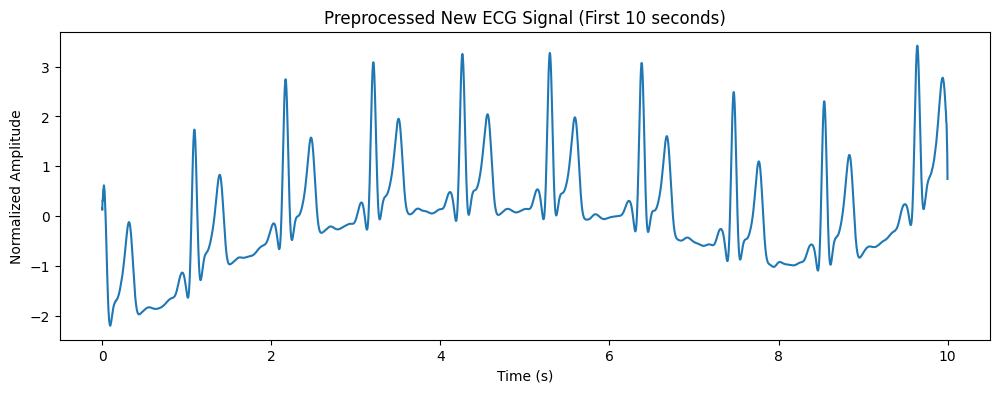

In [12]:
import wfdb
import numpy as np
import matplotlib.pyplot as plt
record_dir='/content/physionet.org/files/edb/1.0.0/'
new_record_name='e0601'
new_record_name =  record_dir + new_record_name  # Change this to the desired record
new_record = wfdb.rdrecord(new_record_name)
new_ecg_signal = new_record.p_signal[:, 0]  # Assuming single-channel ECG
G_fs = new_record.fs
print(G_fs)
new_ecg_signal = new_ecg_signal[int(15 * G_fs):int(25 * G_fs)]
# Example usage
time_axis = np.arange(0, len(new_ecg_signal)) / G_fs  # Time axis in seconds

# Optionally smooth the signal
new_normalized_signal = normalize_signal(smooth_signal(bandpass_filter(new_ecg_signal, 1000), window_size=5))
if G_fs != 360:
            new_normalized_signal = resample_signal(new_normalized_signal, original_fs=G_fs, target_fs=360)
            G_fs = 360

print(G_fs)
# Visualize the preprocessed signal
import matplotlib.pyplot as plt
time_axis = [i / G_fs for i in range(len(new_normalized_signal))]
plt.figure(figsize=(12, 4))
plt.plot(time_axis[:G_fs * 10], new_normalized_signal[:G_fs * 10])
plt.title("Preprocessed New ECG Signal (First 10 seconds)")
plt.xlabel("Time (s)")
plt.ylabel("Normalized Amplitude")
plt.show()




In [13]:



# Segment the normalized signal
QRS_new_segments,QRS_new_start_segments = segment_signal(new_normalized_signal, window_size=QRS_window_size, overlap=QRS_overlap)
P_new_segments,P_new_start_segments = segment_signal(new_normalized_signal, window_size=P_window_size, overlap=P_overlap)
T_new_segments,T_new_start_segments = segment_signal(new_normalized_signal, window_size=T_window_size, overlap=T_overlap)

#print(f"Extracted {len(new_segments)} segments with window size {G_window_size} and {G_overlap} samples overlap.")



In [14]:
# Reshape segments for CNN+LSTM (adding a channel dimension)
QRS_new_segments = QRS_new_segments.reshape(QRS_new_segments.shape[0], QRS_new_segments.shape[1], 1)
P_new_segments = P_new_segments.reshape(P_new_segments.shape[0], P_new_segments.shape[1], 1)
T_new_segments = T_new_segments.reshape(T_new_segments.shape[0], T_new_segments.shape[1], 1)


# Print the shape
print("QRS shape of input segments for model:", QRS_new_segments.shape)
print("P shape of input segments for model:", P_new_segments.shape)
print("T shape of input segments for model:", T_new_segments.shape)


QRS shape of input segments for model: (707, 70, 1)
P shape of input segments for model: (357, 40, 1)
T shape of input segments for model: (708, 65, 1)


#### prediction

In [15]:
# Predict using the trained model
QRS_predictions = QRS_model.predict(QRS_new_segments)
P_predictions = P_model.predict(P_new_segments)
T_predictions = T_model.predict(T_new_segments)


# Convert predictions to binary labels (threshold at 0.5)
QRS_predicted_labels  = ( QRS_predictions > 0.5).astype(int)
T_predicted_labels    = ( T_predictions   > 0.5).astype(int)
P_predicted_labels    = ( P_predictions   > 0.5).astype(int)




23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step


Number of positive (QRS) segments: 63
Number of negative (non-QRS) segments: 644
Number of positive (QRS) segments: 26
Number of negative (non-QRS) segments: 331
Number of positive (QRS) segments: 121
Number of negative (non-QRS) segments: 587


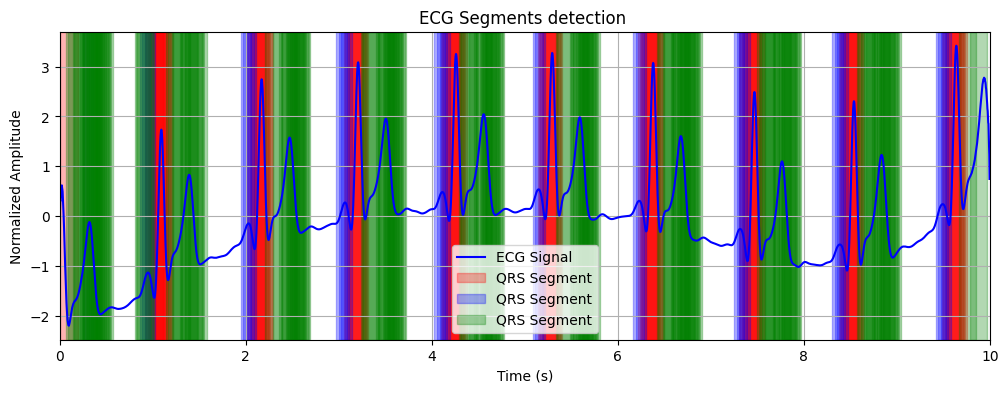

Number of positive (QRS) segments: 63
Number of negative (non-QRS) segments: 644
Number of positive (QRS) segments: 26
Number of negative (non-QRS) segments: 331
Number of positive (QRS) segments: 121
Number of negative (non-QRS) segments: 587


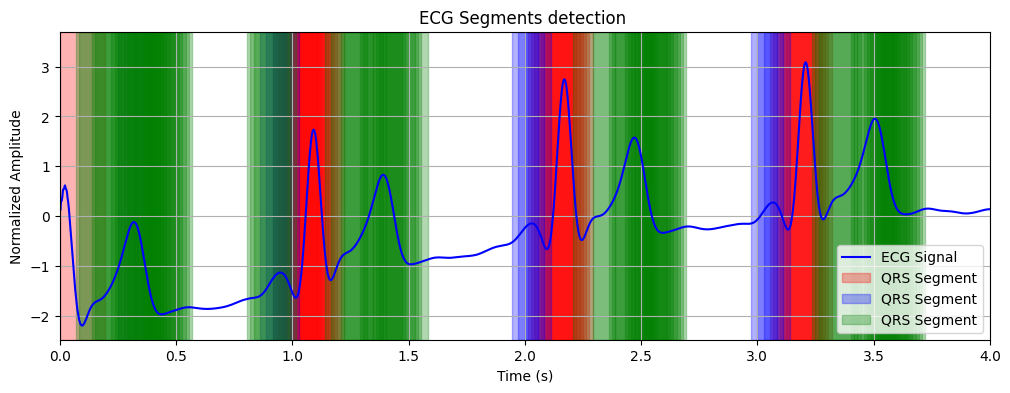

In [16]:
segment_labels=[QRS_predicted_labels,P_predicted_labels,T_predicted_labels]
segment_starts=[QRS_new_start_segments,P_new_start_segments,T_new_start_segments]
display_segment(normalized_signal = new_normalized_signal, segment_labels=segment_labels,segment_starts=segment_starts,z_start=0,z_end=10,window_sizes=display_window_sizes)
display_segment(normalized_signal = new_normalized_signal, segment_labels=segment_labels,segment_starts=segment_starts,z_start=0,z_end=4,window_sizes=display_window_sizes)

Number of positive (QRS) segments: 63
Number of negative (non-QRS) segments: 644


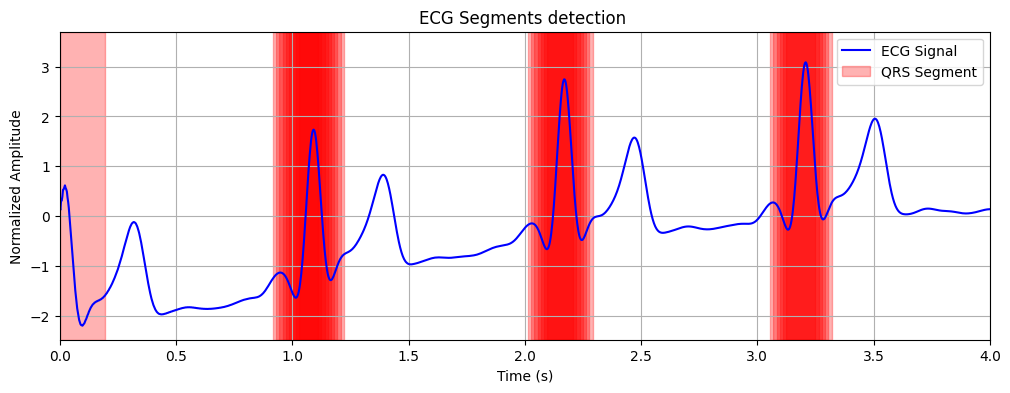

Number of positive (QRS) segments: 121
Number of negative (non-QRS) segments: 587


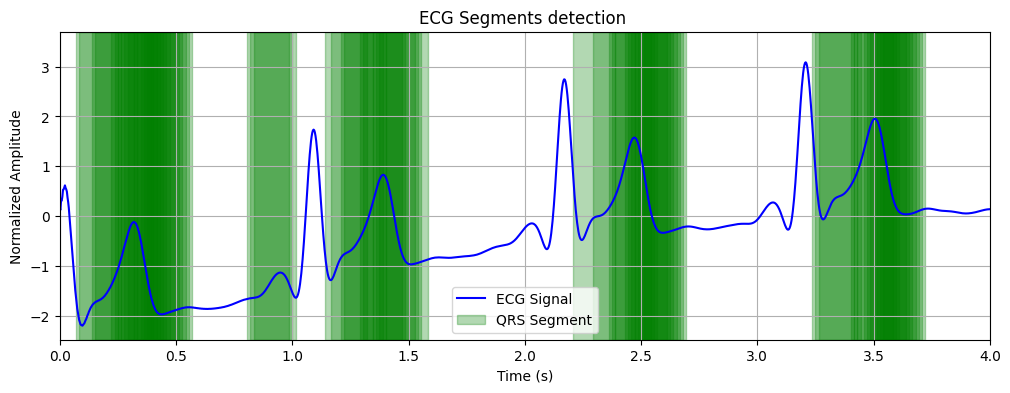

Number of positive (QRS) segments: 26
Number of negative (non-QRS) segments: 331


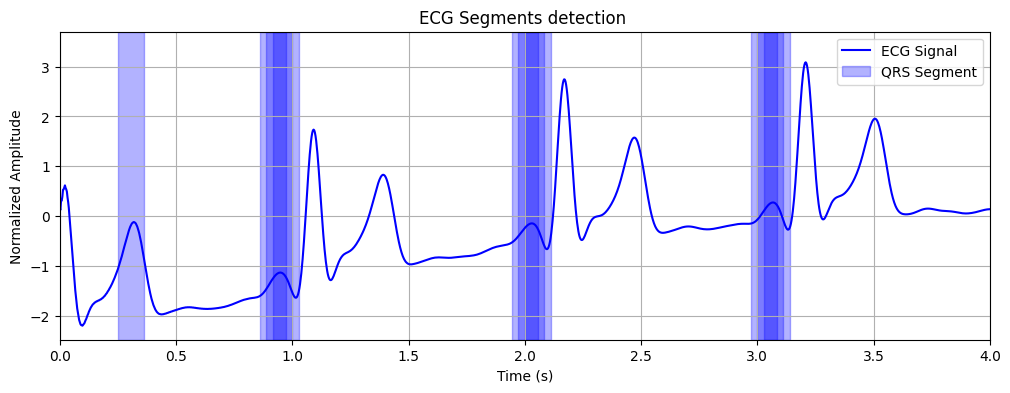

In [17]:
segment_labels=[QRS_predicted_labels,[],[]]
segment_starts=[QRS_new_start_segments,[],[]]
window_sizes = [QRS_window_size,0,0]
display_segment(normalized_signal = new_normalized_signal, segment_labels=segment_labels,segment_starts=segment_starts,z_start=0,z_end=4,window_sizes=window_sizes)

segment_labels=[[],[],T_predicted_labels]
segment_starts=[[],[],T_new_start_segments]
window_sizes = [0,0,T_window_size]
display_segment(normalized_signal = new_normalized_signal, segment_labels=segment_labels,segment_starts=segment_starts,z_start=0,z_end=4,window_sizes=window_sizes)

segment_labels=[[],P_predicted_labels,[]]
segment_starts=[[],P_new_start_segments,[]]
window_sizes = [0,P_window_size,0]
display_segment(normalized_signal = new_normalized_signal, segment_labels=segment_labels,segment_starts=segment_starts,z_start=0,z_end=4,window_sizes=window_sizes)

#### post process

In [18]:
QRS_predicted_labels, QRS_new_segments, QRS_new_start_segments = remove_short_qrs_predictions( QRS_predicted_labels, QRS_new_segments, QRS_new_start_segments,opt="mid")

In [19]:
P_predicted_labels, P_new_segments, P_new_start_segments = remove_consecutive_ones( P_predicted_labels, P_new_segments, P_new_start_segments,opt="mid")

In [20]:
T_predicted_labels, T_new_segments, T_new_start_segments = remove_consecutive_ones( T_predicted_labels, T_new_segments, T_new_start_segments,opt="mid")

In [21]:
QRS_predicted_labels, QRS_new_segments, QRS_new_start_segments = remove_touching_negatives( QRS_predicted_labels, QRS_new_segments, QRS_new_start_segments,QRS_window_size,QRS_overlap)
QRS_predicted_labels, QRS_new_segments, QRS_new_start_segments = remove_consecutive_ones( QRS_predicted_labels, QRS_new_segments, QRS_new_start_segments,opt="mid")


Number of windows to remove: 13


In [22]:
P_predicted_labels, P_new_segments, P_new_start_segments = remove_touching_negatives( P_predicted_labels, P_new_segments, P_new_start_segments,P_window_size,P_overlap)
P_predicted_labels, P_new_segments, P_new_start_segments = remove_consecutive_ones( P_predicted_labels, P_new_segments, P_new_start_segments,opt="mid")


Number of windows to remove: 3


In [23]:
T_predicted_labels, T_new_segments, T_new_start_segments = remove_touching_negatives( T_predicted_labels, T_new_segments, T_new_start_segments,T_window_size,T_overlap)
T_predicted_labels, T_new_segments, T_new_start_segments = remove_consecutive_ones( T_predicted_labels, T_new_segments, T_new_start_segments,opt="mid")

Number of windows to remove: 12


Number of positive (QRS) segments: 9
Number of negative (non-QRS) segments: 409
Number of positive (QRS) segments: 10
Number of negative (non-QRS) segments: 269
Number of positive (QRS) segments: 10
Number of negative (non-QRS) segments: 249


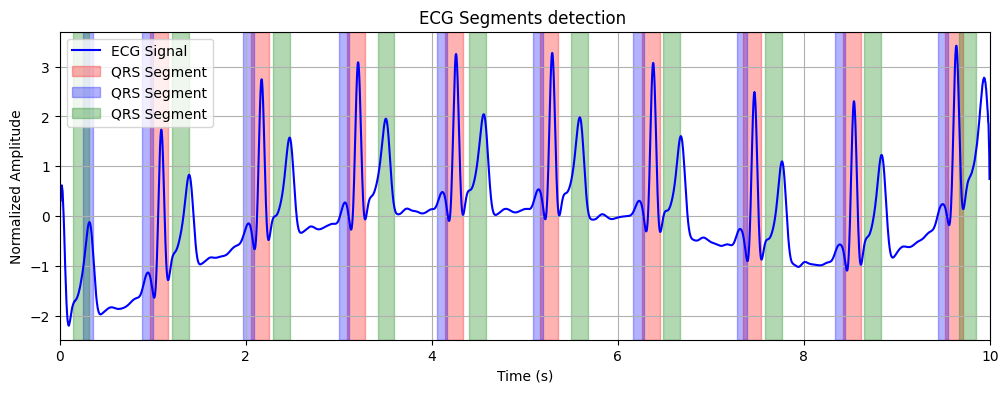

Number of positive (QRS) segments: 9
Number of negative (non-QRS) segments: 409
Number of positive (QRS) segments: 10
Number of negative (non-QRS) segments: 269
Number of positive (QRS) segments: 10
Number of negative (non-QRS) segments: 249


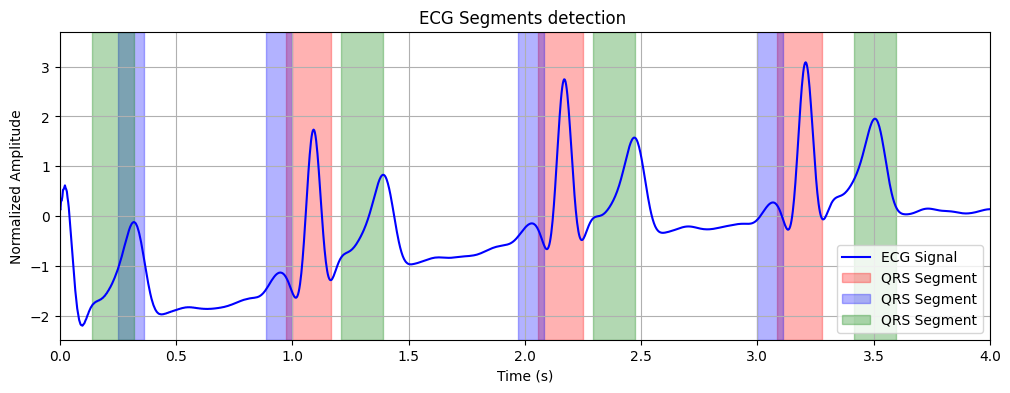

In [24]:
segment_labels=[QRS_predicted_labels,P_predicted_labels,T_predicted_labels]
segment_starts=[QRS_new_start_segments,P_new_start_segments,T_new_start_segments]
display_segment(normalized_signal = new_normalized_signal, segment_labels=segment_labels,segment_starts=segment_starts,z_start=0,z_end=10,window_sizes=display_window_sizes)
display_segment(normalized_signal = new_normalized_signal, segment_labels=segment_labels,segment_starts=segment_starts,z_start=0,z_end=4,window_sizes=display_window_sizes)

Number of positive (QRS) segments: 9
Number of negative (non-QRS) segments: 409


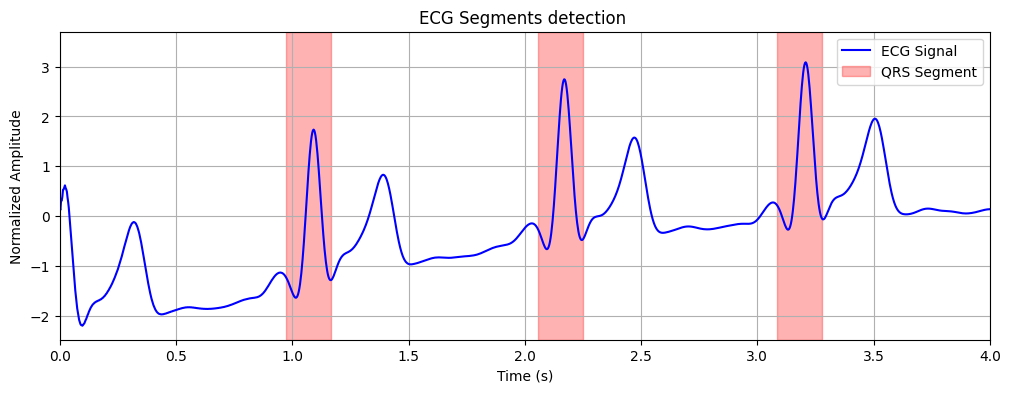

Number of positive (QRS) segments: 10
Number of negative (non-QRS) segments: 249


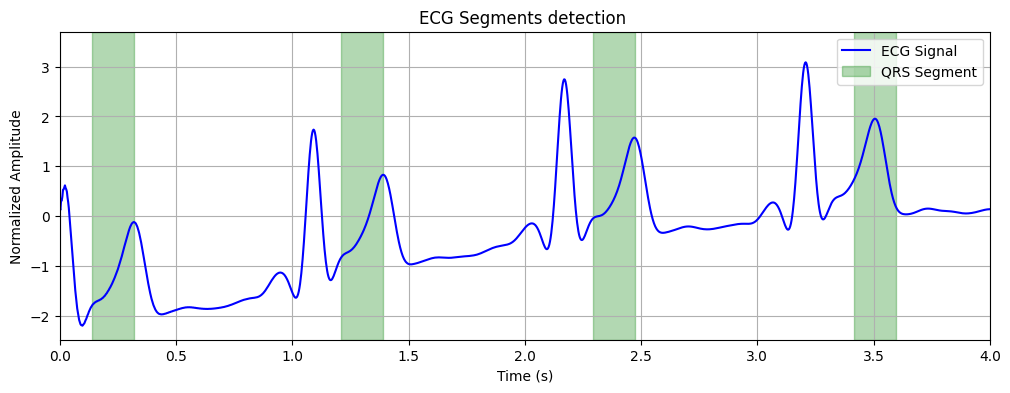

Number of positive (QRS) segments: 10
Number of negative (non-QRS) segments: 269


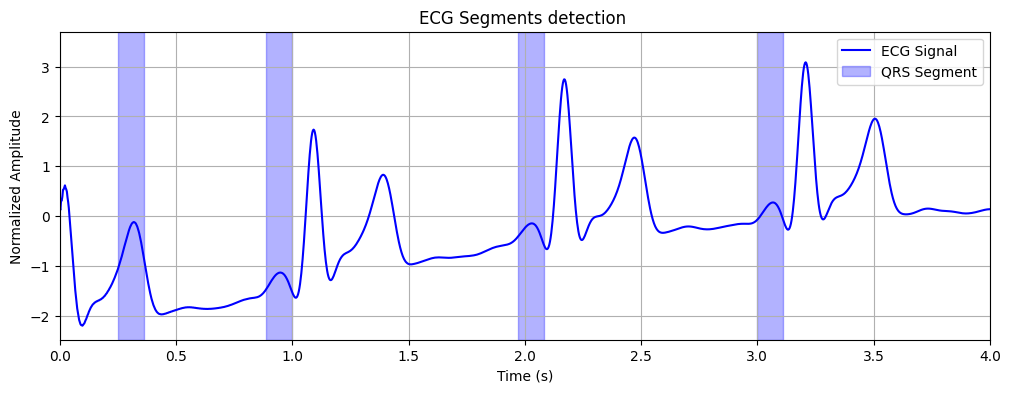

In [25]:
segment_labels=[QRS_predicted_labels,[],[]]
segment_starts=[QRS_new_start_segments,[],[]]
window_sizes = [QRS_window_size,0,0]
display_segment(normalized_signal = new_normalized_signal, segment_labels=segment_labels,segment_starts=segment_starts,z_start=0,z_end=4,window_sizes=window_sizes)

segment_labels=[[],[],T_predicted_labels]
segment_starts=[[],[],T_new_start_segments]
window_sizes = [0,0,T_window_size]
display_segment(normalized_signal = new_normalized_signal, segment_labels=segment_labels,segment_starts=segment_starts,z_start=0,z_end=4,window_sizes=window_sizes)

segment_labels=[[],P_predicted_labels,[]]
segment_starts=[[],P_new_start_segments,[]]
window_sizes = [0,P_window_size,0]
display_segment(normalized_signal = new_normalized_signal, segment_labels=segment_labels,segment_starts=segment_starts,z_start=0,z_end=4,window_sizes=window_sizes)

### edb e0211

#### load signal and preprocess

250
360


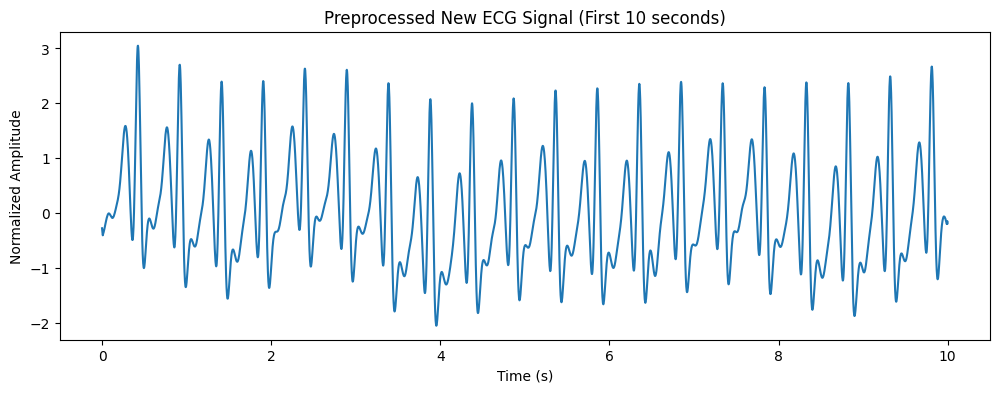

In [26]:
import wfdb
import numpy as np
import matplotlib.pyplot as plt
record_dir='/content/physionet.org/files/edb/1.0.0/'
new_record_name='e0211'
new_record_name =  record_dir + new_record_name  # Change this to the desired record
new_record = wfdb.rdrecord(new_record_name)
new_ecg_signal = new_record.p_signal[:, 0]  # Assuming single-channel ECG
G_fs = new_record.fs
print(G_fs)
new_ecg_signal = new_ecg_signal[int(15 * G_fs):int(25 * G_fs)]
# Example usage
time_axis = np.arange(0, len(new_ecg_signal)) / G_fs  # Time axis in seconds

# Optionally smooth the signal
new_normalized_signal = normalize_signal(smooth_signal(bandpass_filter(new_ecg_signal, 1000), window_size=5))
if G_fs != 360:
            new_normalized_signal = resample_signal(new_normalized_signal, original_fs=G_fs, target_fs=360)
            G_fs = 360

print(G_fs)
# Visualize the preprocessed signal
import matplotlib.pyplot as plt
time_axis = [i / G_fs for i in range(len(new_normalized_signal))]
plt.figure(figsize=(12, 4))
plt.plot(time_axis[:G_fs * 10], new_normalized_signal[:G_fs * 10])
plt.title("Preprocessed New ECG Signal (First 10 seconds)")
plt.xlabel("Time (s)")
plt.ylabel("Normalized Amplitude")
plt.show()




In [27]:



# Segment the normalized signal
QRS_new_segments,QRS_new_start_segments = segment_signal(new_normalized_signal, window_size=QRS_window_size, overlap=QRS_overlap)
P_new_segments,P_new_start_segments = segment_signal(new_normalized_signal, window_size=P_window_size, overlap=P_overlap)
T_new_segments,T_new_start_segments = segment_signal(new_normalized_signal, window_size=T_window_size, overlap=T_overlap)

#print(f"Extracted {len(new_segments)} segments with window size {G_window_size} and {G_overlap} samples overlap.")



In [28]:
# Reshape segments for CNN+LSTM (adding a channel dimension)
QRS_new_segments = QRS_new_segments.reshape(QRS_new_segments.shape[0], QRS_new_segments.shape[1], 1)
P_new_segments = P_new_segments.reshape(P_new_segments.shape[0], P_new_segments.shape[1], 1)
T_new_segments = T_new_segments.reshape(T_new_segments.shape[0], T_new_segments.shape[1], 1)


# Print the shape
print("QRS shape of input segments for model:", QRS_new_segments.shape)
print("P shape of input segments for model:", P_new_segments.shape)
print("T shape of input segments for model:", T_new_segments.shape)


QRS shape of input segments for model: (707, 70, 1)
P shape of input segments for model: (357, 40, 1)
T shape of input segments for model: (708, 65, 1)


#### prediction

In [29]:
# Predict using the trained model
QRS_predictions = QRS_model.predict(QRS_new_segments)
P_predictions = P_model.predict(P_new_segments)
T_predictions = T_model.predict(T_new_segments)


# Convert predictions to binary labels (threshold at 0.5)
QRS_predicted_labels  = ( QRS_predictions > 0.5).astype(int)
T_predicted_labels    = ( T_predictions   > 0.5).astype(int)
P_predicted_labels    = ( P_predictions   > 0.5).astype(int)




23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


Number of positive (QRS) segments: 159
Number of negative (non-QRS) segments: 548
Number of positive (QRS) segments: 20
Number of negative (non-QRS) segments: 337
Number of positive (QRS) segments: 114
Number of negative (non-QRS) segments: 594


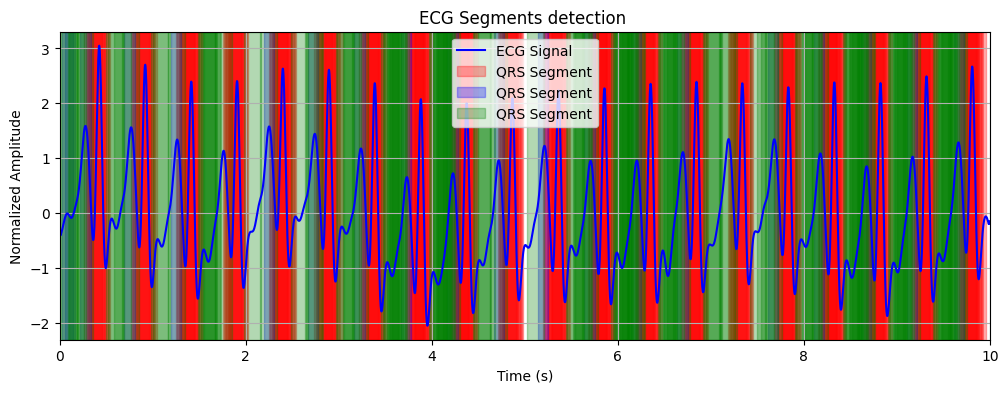

Number of positive (QRS) segments: 159
Number of negative (non-QRS) segments: 548
Number of positive (QRS) segments: 20
Number of negative (non-QRS) segments: 337
Number of positive (QRS) segments: 114
Number of negative (non-QRS) segments: 594


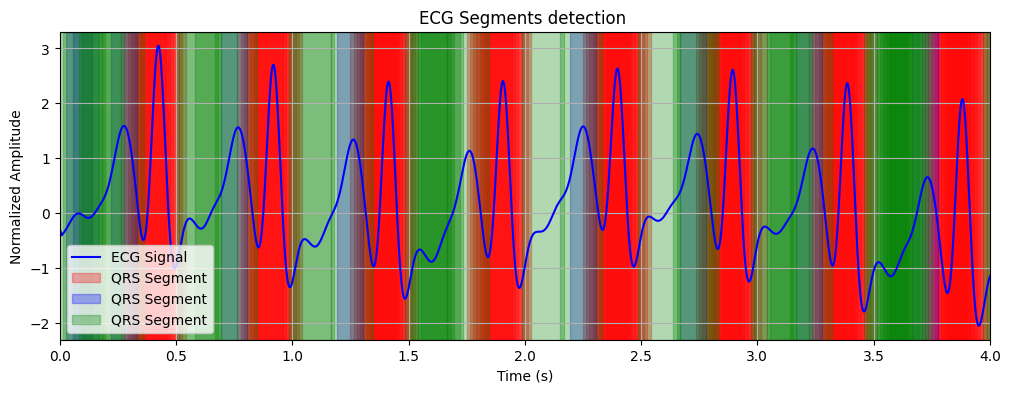

In [30]:
segment_labels=[QRS_predicted_labels,P_predicted_labels,T_predicted_labels]
segment_starts=[QRS_new_start_segments,P_new_start_segments,T_new_start_segments]
display_segment(normalized_signal = new_normalized_signal, segment_labels=segment_labels,segment_starts=segment_starts,z_start=0,z_end=10,window_sizes=display_window_sizes)
display_segment(normalized_signal = new_normalized_signal, segment_labels=segment_labels,segment_starts=segment_starts,z_start=0,z_end=4,window_sizes=display_window_sizes)

Number of positive (QRS) segments: 159
Number of negative (non-QRS) segments: 548


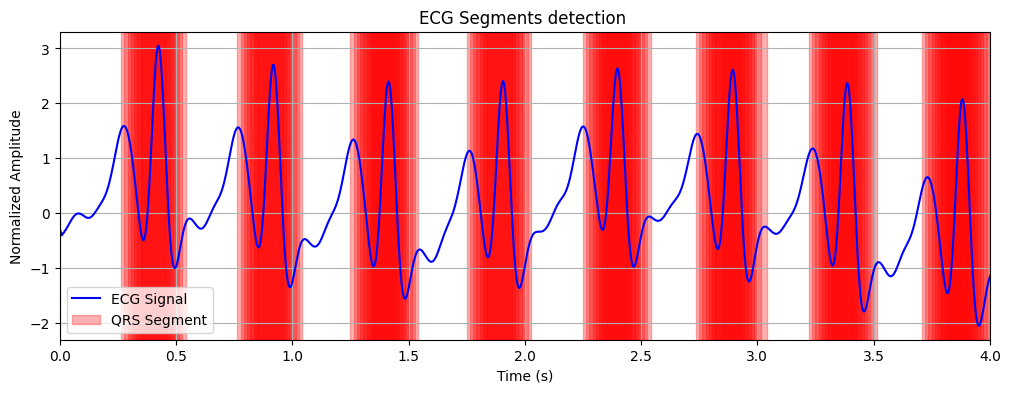

Number of positive (QRS) segments: 114
Number of negative (non-QRS) segments: 594


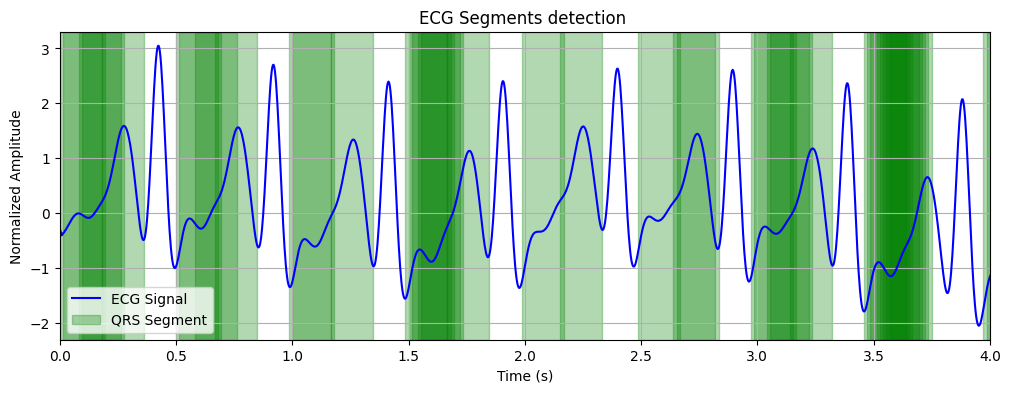

Number of positive (QRS) segments: 20
Number of negative (non-QRS) segments: 337


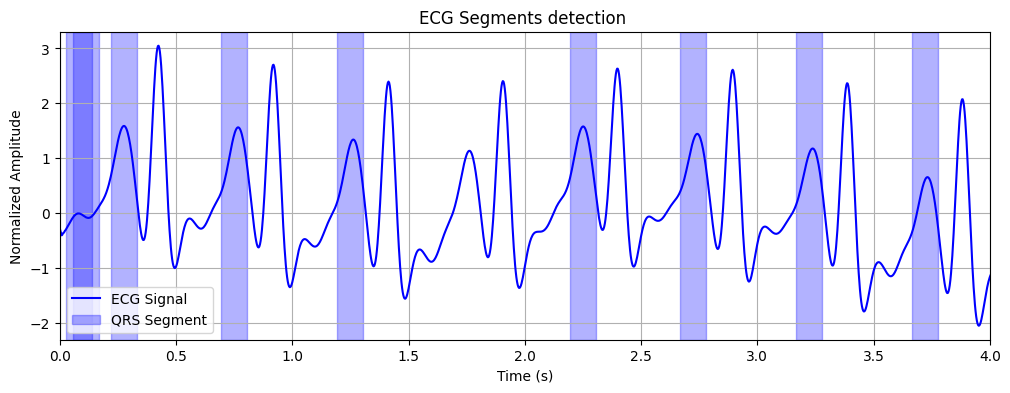

In [31]:
segment_labels=[QRS_predicted_labels,[],[]]
segment_starts=[QRS_new_start_segments,[],[]]
window_sizes = [QRS_window_size,0,0]
display_segment(normalized_signal = new_normalized_signal, segment_labels=segment_labels,segment_starts=segment_starts,z_start=0,z_end=4,window_sizes=window_sizes)

segment_labels=[[],[],T_predicted_labels]
segment_starts=[[],[],T_new_start_segments]
window_sizes = [0,0,T_window_size]
display_segment(normalized_signal = new_normalized_signal, segment_labels=segment_labels,segment_starts=segment_starts,z_start=0,z_end=4,window_sizes=window_sizes)

segment_labels=[[],P_predicted_labels,[]]
segment_starts=[[],P_new_start_segments,[]]
window_sizes = [0,P_window_size,0]
display_segment(normalized_signal = new_normalized_signal, segment_labels=segment_labels,segment_starts=segment_starts,z_start=0,z_end=4,window_sizes=window_sizes)

#### post process

In [32]:
QRS_predicted_labels, QRS_new_segments, QRS_new_start_segments = remove_short_qrs_predictions( QRS_predicted_labels, QRS_new_segments, QRS_new_start_segments,opt="mid")

In [33]:
P_predicted_labels, P_new_segments, P_new_start_segments = remove_consecutive_ones( P_predicted_labels, P_new_segments, P_new_start_segments,opt="mid")

In [34]:
T_predicted_labels, T_new_segments, T_new_start_segments = remove_consecutive_ones( T_predicted_labels, T_new_segments, T_new_start_segments,opt="mid")

In [35]:
QRS_predicted_labels, QRS_new_segments, QRS_new_start_segments = remove_touching_negatives( QRS_predicted_labels, QRS_new_segments, QRS_new_start_segments,QRS_window_size,QRS_overlap)
QRS_predicted_labels, QRS_new_segments, QRS_new_start_segments = remove_consecutive_ones( QRS_predicted_labels, QRS_new_segments, QRS_new_start_segments,opt="mid")


Number of windows to remove: 13


In [36]:
P_predicted_labels, P_new_segments, P_new_start_segments = remove_touching_negatives( P_predicted_labels, P_new_segments, P_new_start_segments,P_window_size,P_overlap)
P_predicted_labels, P_new_segments, P_new_start_segments = remove_consecutive_ones( P_predicted_labels, P_new_segments, P_new_start_segments,opt="mid")


Number of windows to remove: 3


In [37]:
T_predicted_labels, T_new_segments, T_new_start_segments = remove_touching_negatives( T_predicted_labels, T_new_segments, T_new_start_segments,T_window_size,T_overlap)
T_predicted_labels, T_new_segments, T_new_start_segments = remove_consecutive_ones( T_predicted_labels, T_new_segments, T_new_start_segments,opt="mid")

Number of windows to remove: 12


Number of positive (QRS) segments: 17
Number of negative (non-QRS) segments: 37
Number of positive (QRS) segments: 18
Number of negative (non-QRS) segments: 224
Number of positive (QRS) segments: 4
Number of negative (non-QRS) segments: 17


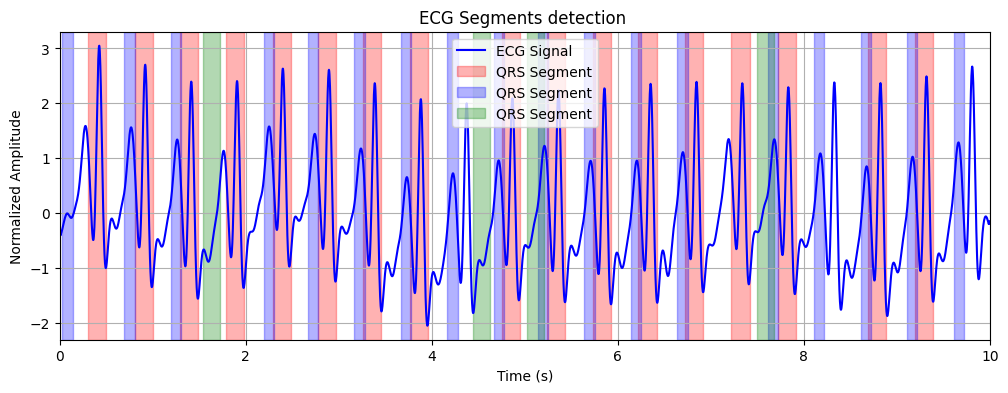

Number of positive (QRS) segments: 17
Number of negative (non-QRS) segments: 37
Number of positive (QRS) segments: 18
Number of negative (non-QRS) segments: 224
Number of positive (QRS) segments: 4
Number of negative (non-QRS) segments: 17


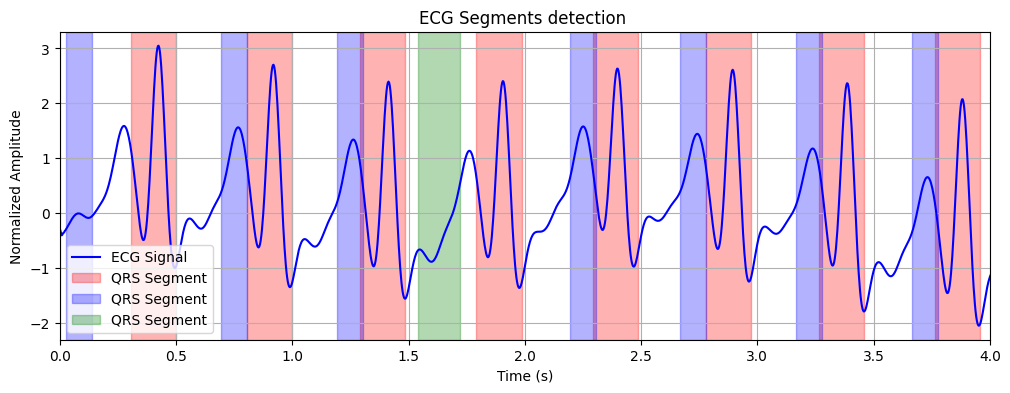

In [38]:
segment_labels=[QRS_predicted_labels,P_predicted_labels,T_predicted_labels]
segment_starts=[QRS_new_start_segments,P_new_start_segments,T_new_start_segments]
display_segment(normalized_signal = new_normalized_signal, segment_labels=segment_labels,segment_starts=segment_starts,z_start=0,z_end=10,window_sizes=display_window_sizes)
display_segment(normalized_signal = new_normalized_signal, segment_labels=segment_labels,segment_starts=segment_starts,z_start=0,z_end=4,window_sizes=display_window_sizes)

Number of positive (QRS) segments: 17
Number of negative (non-QRS) segments: 37


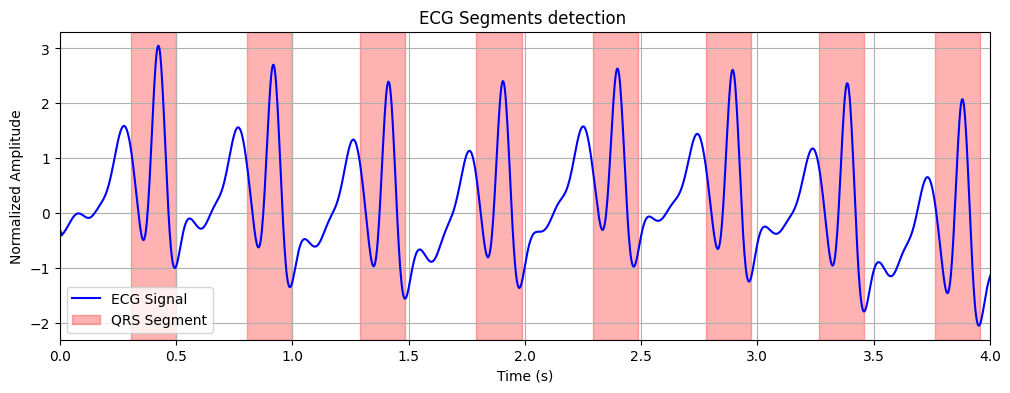

Number of positive (QRS) segments: 4
Number of negative (non-QRS) segments: 17


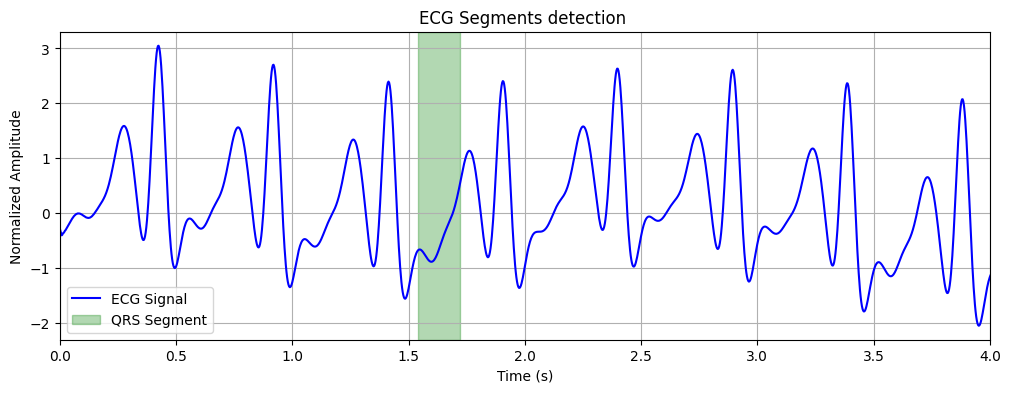

Number of positive (QRS) segments: 18
Number of negative (non-QRS) segments: 224


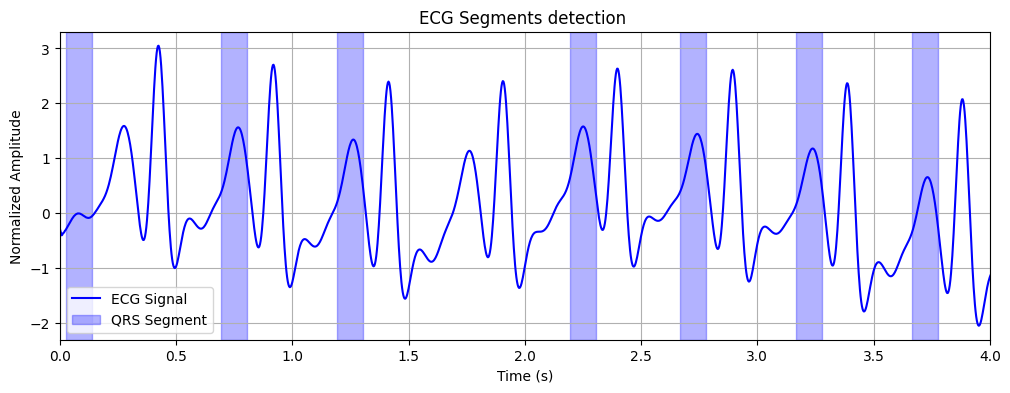

In [39]:
segment_labels=[QRS_predicted_labels,[],[]]
segment_starts=[QRS_new_start_segments,[],[]]
window_sizes = [QRS_window_size,0,0]
display_segment(normalized_signal = new_normalized_signal, segment_labels=segment_labels,segment_starts=segment_starts,z_start=0,z_end=4,window_sizes=window_sizes)

segment_labels=[[],[],T_predicted_labels]
segment_starts=[[],[],T_new_start_segments]
window_sizes = [0,0,T_window_size]
display_segment(normalized_signal = new_normalized_signal, segment_labels=segment_labels,segment_starts=segment_starts,z_start=0,z_end=4,window_sizes=window_sizes)

segment_labels=[[],P_predicted_labels,[]]
segment_starts=[[],P_new_start_segments,[]]
window_sizes = [0,P_window_size,0]
display_segment(normalized_signal = new_normalized_signal, segment_labels=segment_labels,segment_starts=segment_starts,z_start=0,z_end=4,window_sizes=window_sizes)

### edb e1304

#### load signal and preprocess

250
360


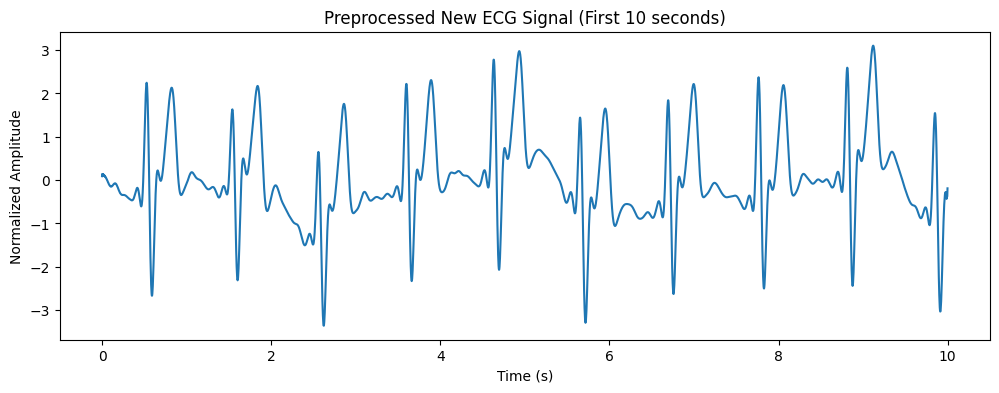

In [40]:
import wfdb
import numpy as np
import matplotlib.pyplot as plt
record_dir='/content/physionet.org/files/edb/1.0.0/'
new_record_name='e1304'
new_record_name =  record_dir + new_record_name  # Change this to the desired record
new_record = wfdb.rdrecord(new_record_name)
new_ecg_signal = new_record.p_signal[:, 0]  # Assuming single-channel ECG
G_fs = new_record.fs
print(G_fs)
new_ecg_signal = new_ecg_signal[int(15 * G_fs):int(25 * G_fs)]
# Example usage
time_axis = np.arange(0, len(new_ecg_signal)) / G_fs  # Time axis in seconds

# Optionally smooth the signal
new_normalized_signal = normalize_signal(smooth_signal(bandpass_filter(new_ecg_signal, 1000), window_size=5))
if G_fs != 360:
            new_normalized_signal = resample_signal(new_normalized_signal, original_fs=G_fs, target_fs=360)
            G_fs = 360

print(G_fs)
# Visualize the preprocessed signal
import matplotlib.pyplot as plt
time_axis = [i / G_fs for i in range(len(new_normalized_signal))]
plt.figure(figsize=(12, 4))
plt.plot(time_axis[:G_fs * 10], new_normalized_signal[:G_fs * 10])
plt.title("Preprocessed New ECG Signal (First 10 seconds)")
plt.xlabel("Time (s)")
plt.ylabel("Normalized Amplitude")
plt.show()




In [41]:



# Segment the normalized signal
QRS_new_segments,QRS_new_start_segments = segment_signal(new_normalized_signal, window_size=QRS_window_size, overlap=QRS_overlap)
P_new_segments,P_new_start_segments = segment_signal(new_normalized_signal, window_size=P_window_size, overlap=P_overlap)
T_new_segments,T_new_start_segments = segment_signal(new_normalized_signal, window_size=T_window_size, overlap=T_overlap)

#print(f"Extracted {len(new_segments)} segments with window size {G_window_size} and {G_overlap} samples overlap.")



In [42]:
# Reshape segments for CNN+LSTM (adding a channel dimension)
QRS_new_segments = QRS_new_segments.reshape(QRS_new_segments.shape[0], QRS_new_segments.shape[1], 1)
P_new_segments = P_new_segments.reshape(P_new_segments.shape[0], P_new_segments.shape[1], 1)
T_new_segments = T_new_segments.reshape(T_new_segments.shape[0], T_new_segments.shape[1], 1)


# Print the shape
print("QRS shape of input segments for model:", QRS_new_segments.shape)
print("P shape of input segments for model:", P_new_segments.shape)
print("T shape of input segments for model:", T_new_segments.shape)


QRS shape of input segments for model: (707, 70, 1)
P shape of input segments for model: (357, 40, 1)
T shape of input segments for model: (708, 65, 1)


#### prediction

In [43]:
# Predict using the trained model
QRS_predictions = QRS_model.predict(QRS_new_segments)
P_predictions = P_model.predict(P_new_segments)
T_predictions = T_model.predict(T_new_segments)


# Convert predictions to binary labels (threshold at 0.5)
QRS_predicted_labels  = ( QRS_predictions > 0.5).astype(int)
T_predicted_labels    = ( T_predictions   > 0.5).astype(int)
P_predicted_labels    = ( P_predictions   > 0.5).astype(int)




23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


Number of positive (QRS) segments: 77
Number of negative (non-QRS) segments: 630
Number of positive (QRS) segments: 46
Number of negative (non-QRS) segments: 311
Number of positive (QRS) segments: 145
Number of negative (non-QRS) segments: 563


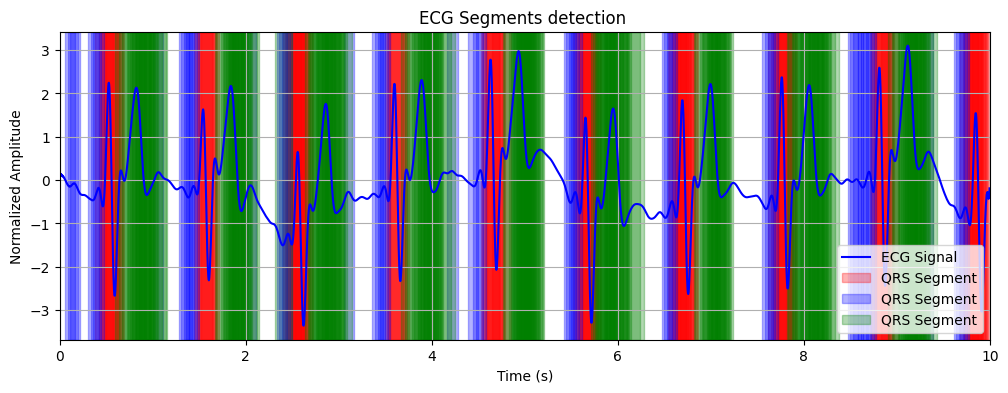

Number of positive (QRS) segments: 77
Number of negative (non-QRS) segments: 630
Number of positive (QRS) segments: 46
Number of negative (non-QRS) segments: 311
Number of positive (QRS) segments: 145
Number of negative (non-QRS) segments: 563


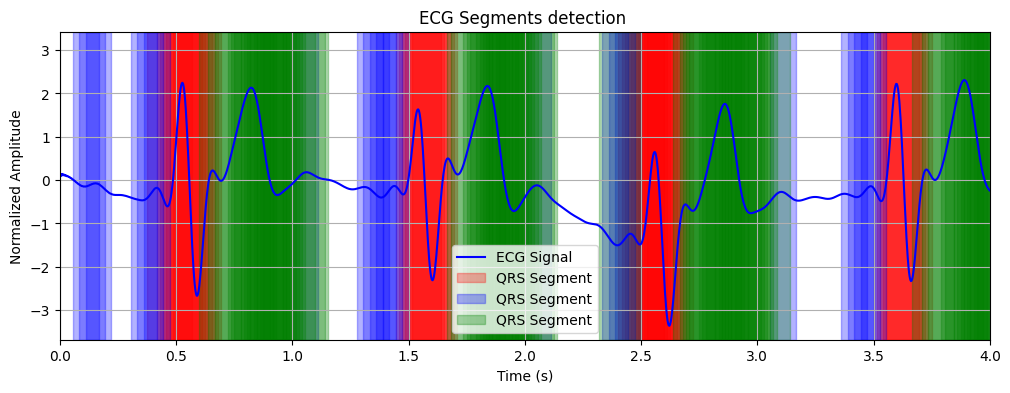

In [44]:
segment_labels=[QRS_predicted_labels,P_predicted_labels,T_predicted_labels]
segment_starts=[QRS_new_start_segments,P_new_start_segments,T_new_start_segments]
display_segment(normalized_signal = new_normalized_signal, segment_labels=segment_labels,segment_starts=segment_starts,z_start=0,z_end=10,window_sizes=display_window_sizes)
display_segment(normalized_signal = new_normalized_signal, segment_labels=segment_labels,segment_starts=segment_starts,z_start=0,z_end=4,window_sizes=display_window_sizes)

Number of positive (QRS) segments: 77
Number of negative (non-QRS) segments: 630


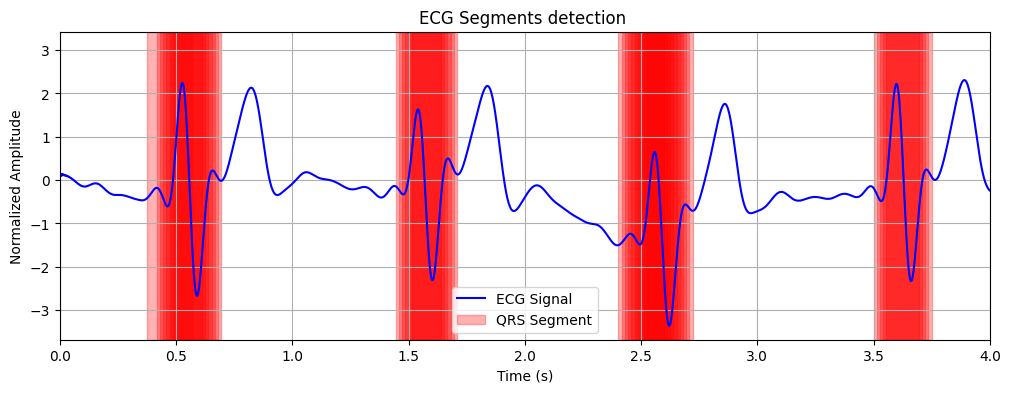

Number of positive (QRS) segments: 145
Number of negative (non-QRS) segments: 563


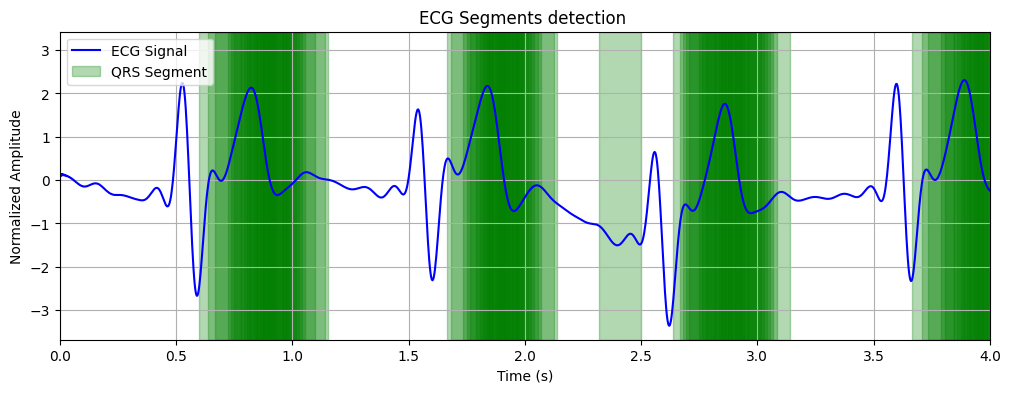

Number of positive (QRS) segments: 46
Number of negative (non-QRS) segments: 311


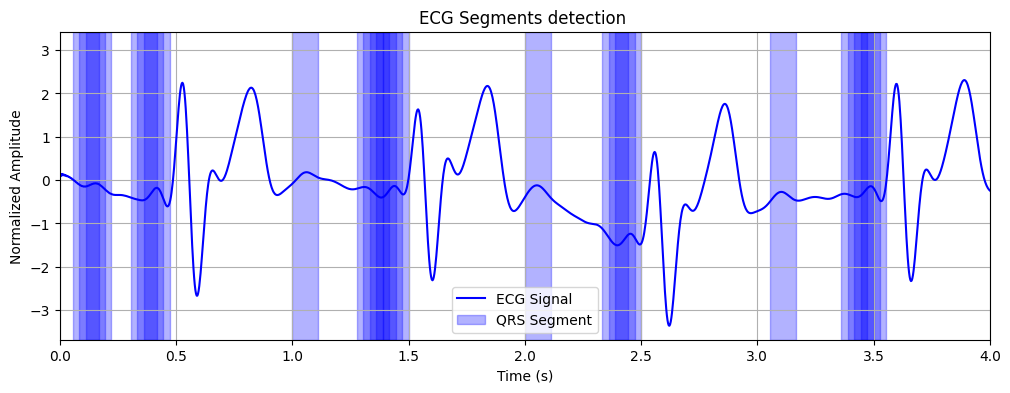

In [45]:
segment_labels=[QRS_predicted_labels,[],[]]
segment_starts=[QRS_new_start_segments,[],[]]
window_sizes = [QRS_window_size,0,0]
display_segment(normalized_signal = new_normalized_signal, segment_labels=segment_labels,segment_starts=segment_starts,z_start=0,z_end=4,window_sizes=window_sizes)

segment_labels=[[],[],T_predicted_labels]
segment_starts=[[],[],T_new_start_segments]
window_sizes = [0,0,T_window_size]
display_segment(normalized_signal = new_normalized_signal, segment_labels=segment_labels,segment_starts=segment_starts,z_start=0,z_end=4,window_sizes=window_sizes)

segment_labels=[[],P_predicted_labels,[]]
segment_starts=[[],P_new_start_segments,[]]
window_sizes = [0,P_window_size,0]
display_segment(normalized_signal = new_normalized_signal, segment_labels=segment_labels,segment_starts=segment_starts,z_start=0,z_end=4,window_sizes=window_sizes)

#### post process

In [46]:
QRS_predicted_labels, QRS_new_segments, QRS_new_start_segments = remove_short_qrs_predictions( QRS_predicted_labels, QRS_new_segments, QRS_new_start_segments,opt="mid")

In [47]:
P_predicted_labels, P_new_segments, P_new_start_segments = remove_consecutive_ones( P_predicted_labels, P_new_segments, P_new_start_segments,opt="mid")

In [48]:
T_predicted_labels, T_new_segments, T_new_start_segments = remove_consecutive_ones( T_predicted_labels, T_new_segments, T_new_start_segments,opt="mid")

In [49]:
QRS_predicted_labels, QRS_new_segments, QRS_new_start_segments = remove_touching_negatives( QRS_predicted_labels, QRS_new_segments, QRS_new_start_segments,QRS_window_size,QRS_overlap)
QRS_predicted_labels, QRS_new_segments, QRS_new_start_segments = remove_consecutive_ones( QRS_predicted_labels, QRS_new_segments, QRS_new_start_segments,opt="mid")


Number of windows to remove: 13


In [50]:
P_predicted_labels, P_new_segments, P_new_start_segments = remove_touching_negatives( P_predicted_labels, P_new_segments, P_new_start_segments,P_window_size,P_overlap)
P_predicted_labels, P_new_segments, P_new_start_segments = remove_consecutive_ones( P_predicted_labels, P_new_segments, P_new_start_segments,opt="mid")


Number of windows to remove: 3


In [51]:
T_predicted_labels, T_new_segments, T_new_start_segments = remove_touching_negatives( T_predicted_labels, T_new_segments, T_new_start_segments,T_window_size,T_overlap)
T_predicted_labels, T_new_segments, T_new_start_segments = remove_consecutive_ones( T_predicted_labels, T_new_segments, T_new_start_segments,opt="mid")

Number of windows to remove: 12


Number of positive (QRS) segments: 9
Number of negative (non-QRS) segments: 383
Number of positive (QRS) segments: 15
Number of negative (non-QRS) segments: 212
Number of positive (QRS) segments: 9
Number of negative (non-QRS) segments: 242


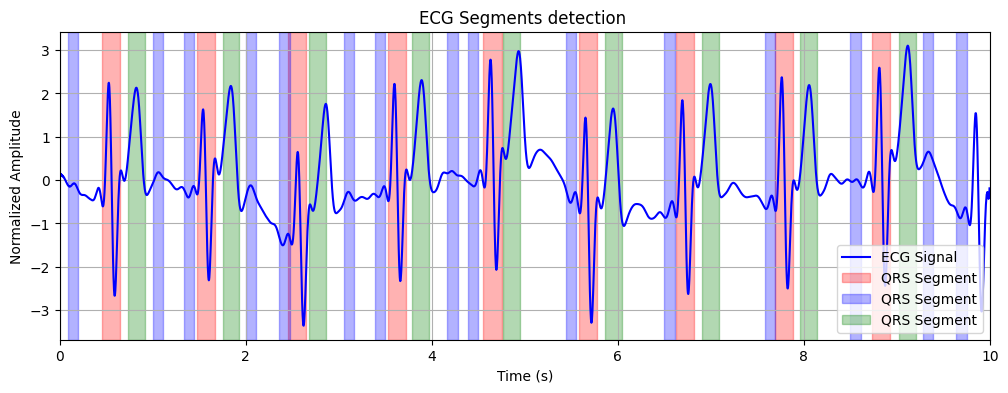

Number of positive (QRS) segments: 9
Number of negative (non-QRS) segments: 383
Number of positive (QRS) segments: 15
Number of negative (non-QRS) segments: 212
Number of positive (QRS) segments: 9
Number of negative (non-QRS) segments: 242


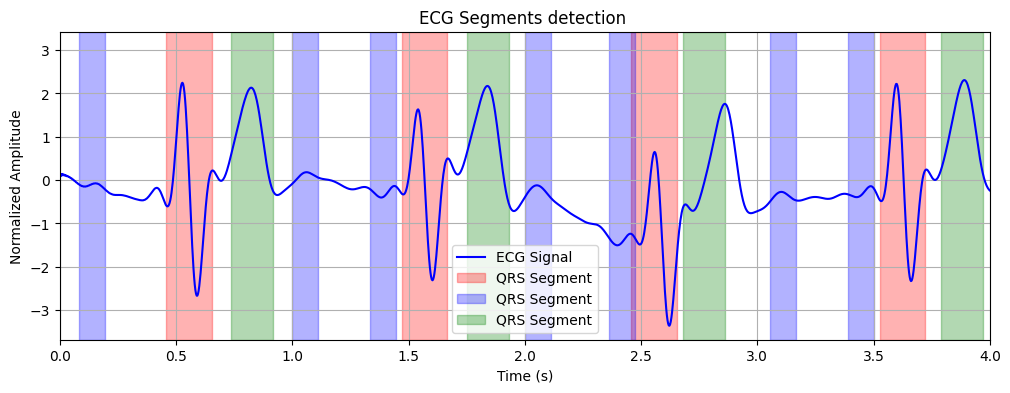

In [52]:
segment_labels=[QRS_predicted_labels,P_predicted_labels,T_predicted_labels]
segment_starts=[QRS_new_start_segments,P_new_start_segments,T_new_start_segments]
display_segment(normalized_signal = new_normalized_signal, segment_labels=segment_labels,segment_starts=segment_starts,z_start=0,z_end=10,window_sizes=display_window_sizes)
display_segment(normalized_signal = new_normalized_signal, segment_labels=segment_labels,segment_starts=segment_starts,z_start=0,z_end=4,window_sizes=display_window_sizes)

Number of positive (QRS) segments: 9
Number of negative (non-QRS) segments: 383


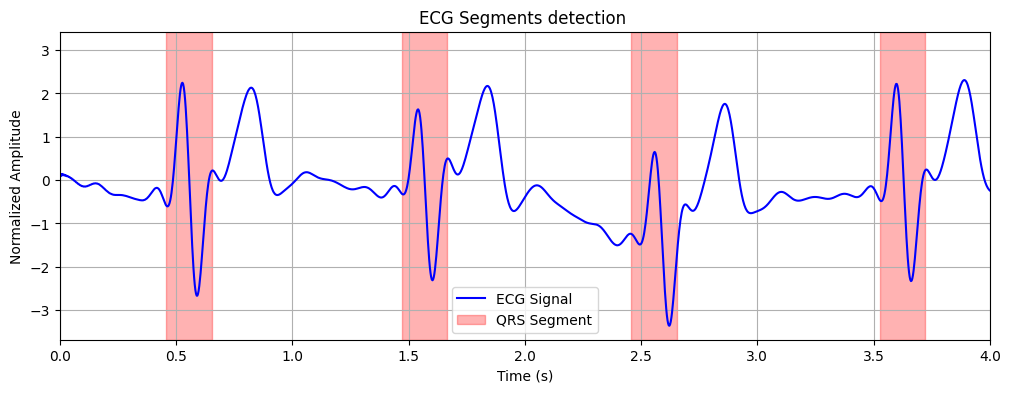

Number of positive (QRS) segments: 9
Number of negative (non-QRS) segments: 242


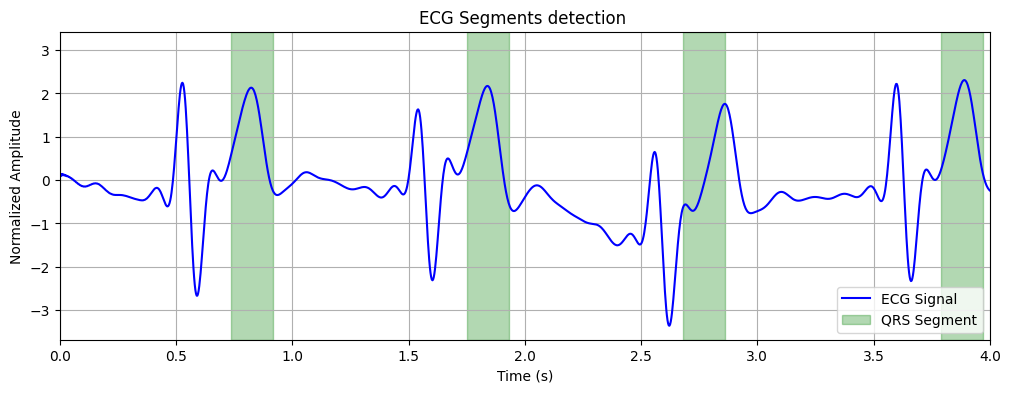

Number of positive (QRS) segments: 15
Number of negative (non-QRS) segments: 212


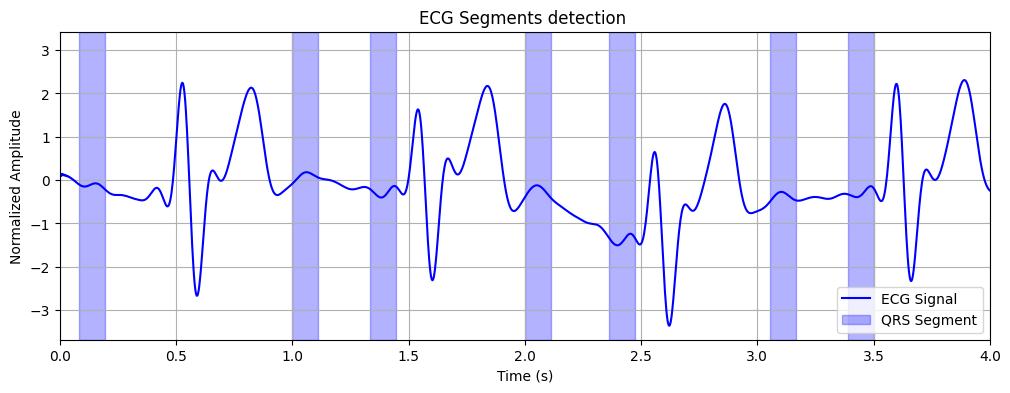

In [53]:
segment_labels=[QRS_predicted_labels,[],[]]
segment_starts=[QRS_new_start_segments,[],[]]
window_sizes = [QRS_window_size,0,0]
display_segment(normalized_signal = new_normalized_signal, segment_labels=segment_labels,segment_starts=segment_starts,z_start=0,z_end=4,window_sizes=window_sizes)

segment_labels=[[],[],T_predicted_labels]
segment_starts=[[],[],T_new_start_segments]
window_sizes = [0,0,T_window_size]
display_segment(normalized_signal = new_normalized_signal, segment_labels=segment_labels,segment_starts=segment_starts,z_start=0,z_end=4,window_sizes=window_sizes)

segment_labels=[[],P_predicted_labels,[]]
segment_starts=[[],P_new_start_segments,[]]
window_sizes = [0,P_window_size,0]
display_segment(normalized_signal = new_normalized_signal, segment_labels=segment_labels,segment_starts=segment_starts,z_start=0,z_end=4,window_sizes=window_sizes)

### ecgiddb Person_02/rec_1

#### load signal and preprocess

500
360


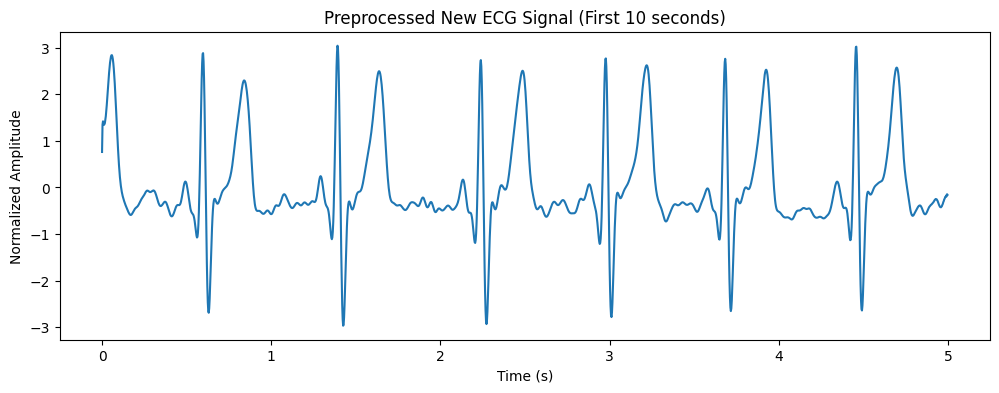

In [54]:
import wfdb
import numpy as np
import matplotlib.pyplot as plt
record_dir='/content/drive/MyDrive/Final project/dataset/physionet.org/files/ecgiddb/1.0.0/'
new_record_name='Person_02/rec_1'
new_record_name =  record_dir + new_record_name  # Change this to the desired record
new_record = wfdb.rdrecord(new_record_name)
new_ecg_signal = new_record.p_signal[:, 0]  # Assuming single-channel ECG
G_fs = new_record.fs
print(G_fs)
new_ecg_signal = new_ecg_signal[int(15 * G_fs):int(25 * G_fs)]
# Example usage
time_axis = np.arange(0, len(new_ecg_signal)) / G_fs  # Time axis in seconds

# Optionally smooth the signal
new_normalized_signal = normalize_signal(smooth_signal(bandpass_filter(new_ecg_signal, 1000), window_size=5))
if G_fs != 360:
            new_normalized_signal = resample_signal(new_normalized_signal, original_fs=G_fs, target_fs=360)
            G_fs = 360

print(G_fs)
# Visualize the preprocessed signal
import matplotlib.pyplot as plt
time_axis = [i / G_fs for i in range(len(new_normalized_signal))]
plt.figure(figsize=(12, 4))
plt.plot(time_axis[:G_fs * 10], new_normalized_signal[:G_fs * 10])
plt.title("Preprocessed New ECG Signal (First 10 seconds)")
plt.xlabel("Time (s)")
plt.ylabel("Normalized Amplitude")
plt.show()




In [55]:



# Segment the normalized signal
QRS_new_segments,QRS_new_start_segments = segment_signal(new_normalized_signal, window_size=QRS_window_size, overlap=QRS_overlap)
P_new_segments,P_new_start_segments = segment_signal(new_normalized_signal, window_size=P_window_size, overlap=P_overlap)
T_new_segments,T_new_start_segments = segment_signal(new_normalized_signal, window_size=T_window_size, overlap=T_overlap)

#print(f"Extracted {len(new_segments)} segments with window size {G_window_size} and {G_overlap} samples overlap.")



In [56]:
# Reshape segments for CNN+LSTM (adding a channel dimension)
QRS_new_segments = QRS_new_segments.reshape(QRS_new_segments.shape[0], QRS_new_segments.shape[1], 1)
P_new_segments = P_new_segments.reshape(P_new_segments.shape[0], P_new_segments.shape[1], 1)
T_new_segments = T_new_segments.reshape(T_new_segments.shape[0], T_new_segments.shape[1], 1)


# Print the shape
print("QRS shape of input segments for model:", QRS_new_segments.shape)
print("P shape of input segments for model:", P_new_segments.shape)
print("T shape of input segments for model:", T_new_segments.shape)


QRS shape of input segments for model: (347, 70, 1)
P shape of input segments for model: (177, 40, 1)
T shape of input segments for model: (348, 65, 1)


#### prediction

In [57]:
# Predict using the trained model
QRS_predictions = QRS_model.predict(QRS_new_segments)
P_predictions = P_model.predict(P_new_segments)
T_predictions = T_model.predict(T_new_segments)


# Convert predictions to binary labels (threshold at 0.5)
QRS_predicted_labels  = ( QRS_predictions > 0.5).astype(int)
T_predicted_labels    = ( T_predictions   > 0.5).astype(int)
P_predicted_labels    = ( P_predictions   > 0.5).astype(int)




11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


Number of positive (QRS) segments: 53
Number of negative (non-QRS) segments: 294
Number of positive (QRS) segments: 26
Number of negative (non-QRS) segments: 151
Number of positive (QRS) segments: 52
Number of negative (non-QRS) segments: 296


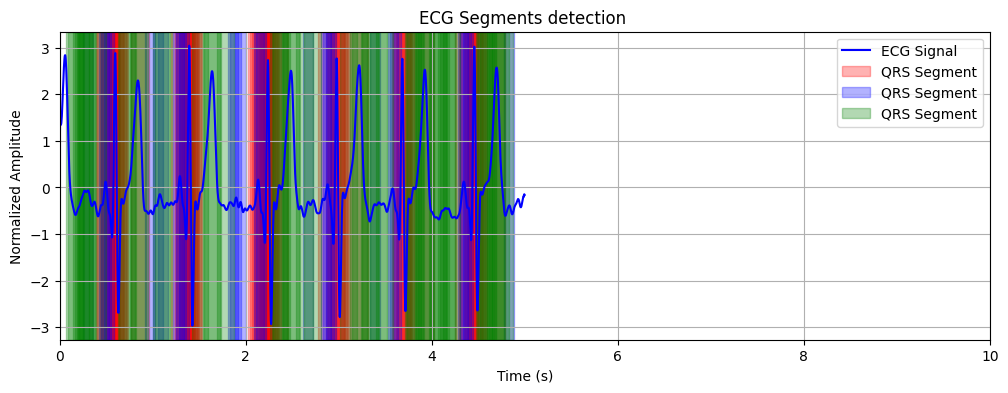

Number of positive (QRS) segments: 53
Number of negative (non-QRS) segments: 294
Number of positive (QRS) segments: 26
Number of negative (non-QRS) segments: 151
Number of positive (QRS) segments: 52
Number of negative (non-QRS) segments: 296


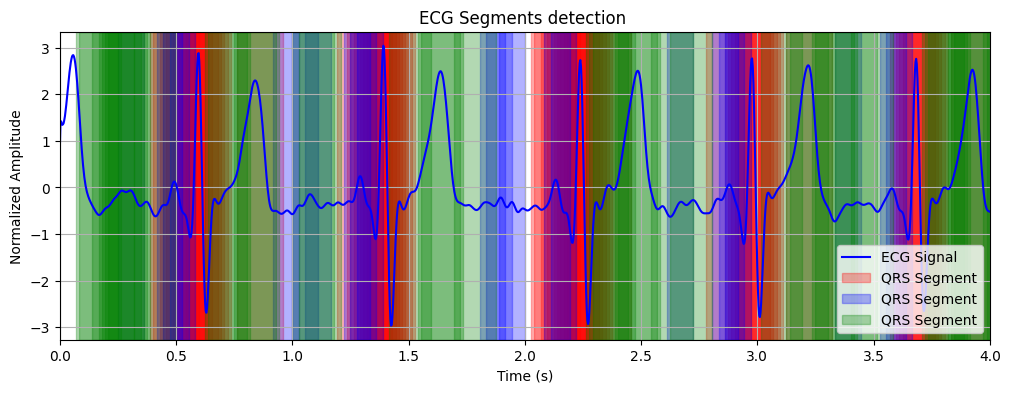

In [58]:
segment_labels=[QRS_predicted_labels,P_predicted_labels,T_predicted_labels]
segment_starts=[QRS_new_start_segments,P_new_start_segments,T_new_start_segments]
display_segment(normalized_signal = new_normalized_signal, segment_labels=segment_labels,segment_starts=segment_starts,z_start=0,z_end=10,window_sizes=display_window_sizes)
display_segment(normalized_signal = new_normalized_signal, segment_labels=segment_labels,segment_starts=segment_starts,z_start=0,z_end=4,window_sizes=display_window_sizes)

Number of positive (QRS) segments: 53
Number of negative (non-QRS) segments: 294


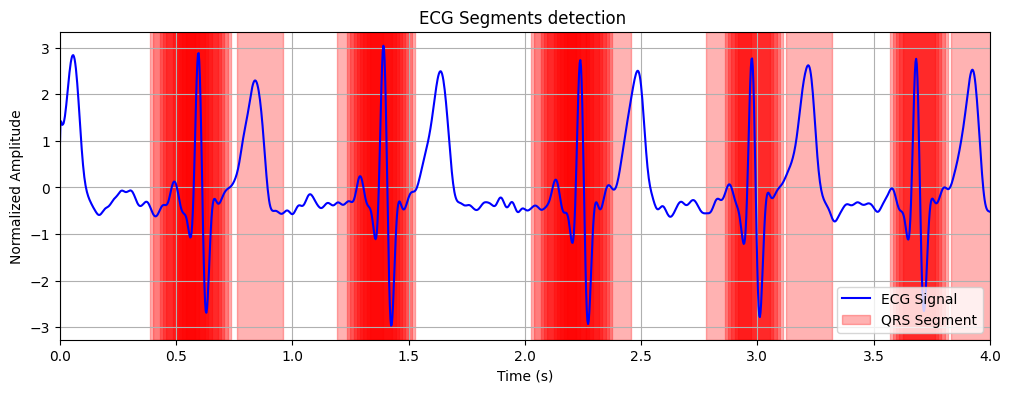

Number of positive (QRS) segments: 52
Number of negative (non-QRS) segments: 296


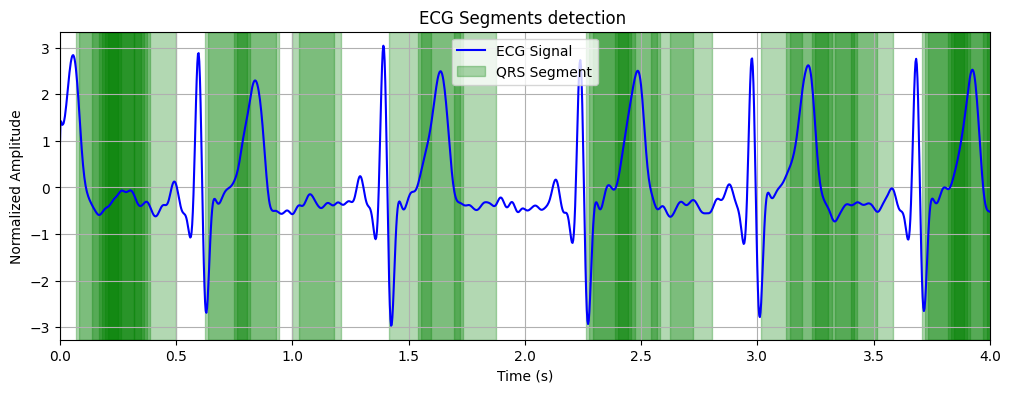

Number of positive (QRS) segments: 26
Number of negative (non-QRS) segments: 151


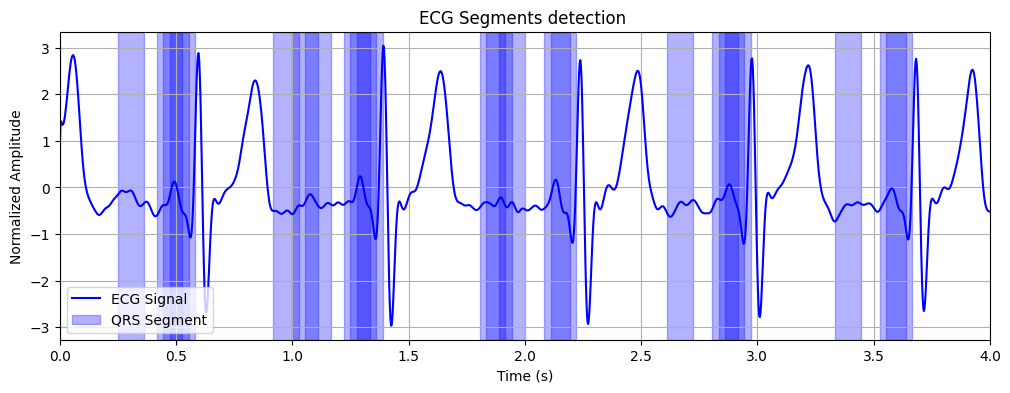

In [59]:
segment_labels=[QRS_predicted_labels,[],[]]
segment_starts=[QRS_new_start_segments,[],[]]
window_sizes = [QRS_window_size,0,0]
display_segment(normalized_signal = new_normalized_signal, segment_labels=segment_labels,segment_starts=segment_starts,z_start=0,z_end=4,window_sizes=window_sizes)

segment_labels=[[],[],T_predicted_labels]
segment_starts=[[],[],T_new_start_segments]
window_sizes = [0,0,T_window_size]
display_segment(normalized_signal = new_normalized_signal, segment_labels=segment_labels,segment_starts=segment_starts,z_start=0,z_end=4,window_sizes=window_sizes)

segment_labels=[[],P_predicted_labels,[]]
segment_starts=[[],P_new_start_segments,[]]
window_sizes = [0,P_window_size,0]
display_segment(normalized_signal = new_normalized_signal, segment_labels=segment_labels,segment_starts=segment_starts,z_start=0,z_end=4,window_sizes=window_sizes)

#### post process

In [60]:
QRS_predicted_labels, QRS_new_segments, QRS_new_start_segments = remove_short_qrs_predictions( QRS_predicted_labels, QRS_new_segments, QRS_new_start_segments,opt="mid")

In [61]:
P_predicted_labels, P_new_segments, P_new_start_segments = remove_consecutive_ones( P_predicted_labels, P_new_segments, P_new_start_segments,opt="mid")

In [62]:
T_predicted_labels, T_new_segments, T_new_start_segments = remove_consecutive_ones( T_predicted_labels, T_new_segments, T_new_start_segments,opt="mid")

In [63]:
QRS_predicted_labels, QRS_new_segments, QRS_new_start_segments = remove_touching_negatives( QRS_predicted_labels, QRS_new_segments, QRS_new_start_segments,QRS_window_size,QRS_overlap)
QRS_predicted_labels, QRS_new_segments, QRS_new_start_segments = remove_consecutive_ones( QRS_predicted_labels, QRS_new_segments, QRS_new_start_segments,opt="mid")


Number of windows to remove: 13


In [64]:
P_predicted_labels, P_new_segments, P_new_start_segments = remove_touching_negatives( P_predicted_labels, P_new_segments, P_new_start_segments,P_window_size,P_overlap)
P_predicted_labels, P_new_segments, P_new_start_segments = remove_consecutive_ones( P_predicted_labels, P_new_segments, P_new_start_segments,opt="mid")


Number of windows to remove: 3


In [65]:
T_predicted_labels, T_new_segments, T_new_start_segments = remove_touching_negatives( T_predicted_labels, T_new_segments, T_new_start_segments,T_window_size,T_overlap)
T_predicted_labels, T_new_segments, T_new_start_segments = remove_consecutive_ones( T_predicted_labels, T_new_segments, T_new_start_segments,opt="mid")

Number of windows to remove: 12


Number of positive (QRS) segments: 6
Number of negative (non-QRS) segments: 137
Number of positive (QRS) segments: 6
Number of negative (non-QRS) segments: 76
Number of positive (QRS) segments: 4
Number of negative (non-QRS) segments: 22


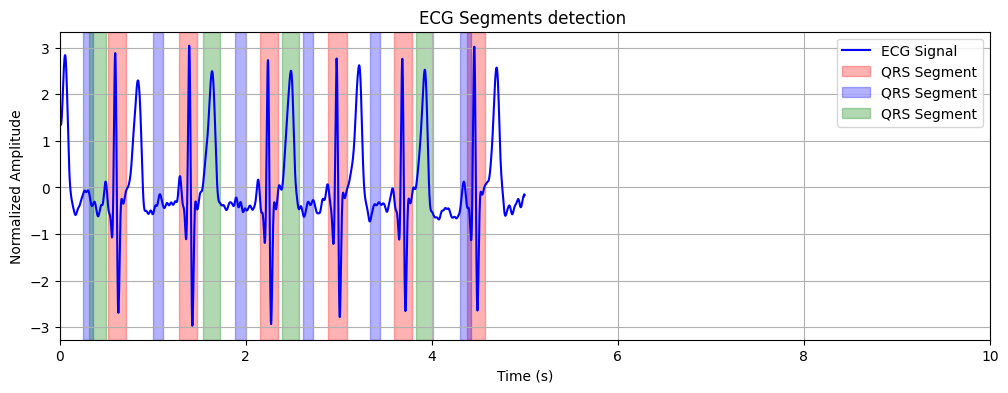

Number of positive (QRS) segments: 6
Number of negative (non-QRS) segments: 137
Number of positive (QRS) segments: 6
Number of negative (non-QRS) segments: 76
Number of positive (QRS) segments: 4
Number of negative (non-QRS) segments: 22


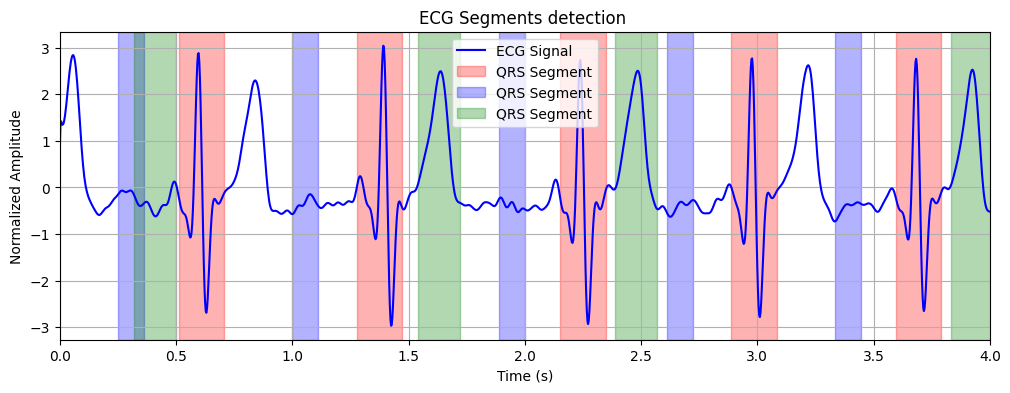

In [66]:
segment_labels=[QRS_predicted_labels,P_predicted_labels,T_predicted_labels]
segment_starts=[QRS_new_start_segments,P_new_start_segments,T_new_start_segments]
display_segment(normalized_signal = new_normalized_signal, segment_labels=segment_labels,segment_starts=segment_starts,z_start=0,z_end=10,window_sizes=display_window_sizes)
display_segment(normalized_signal = new_normalized_signal, segment_labels=segment_labels,segment_starts=segment_starts,z_start=0,z_end=4,window_sizes=display_window_sizes)

Number of positive (QRS) segments: 6
Number of negative (non-QRS) segments: 137


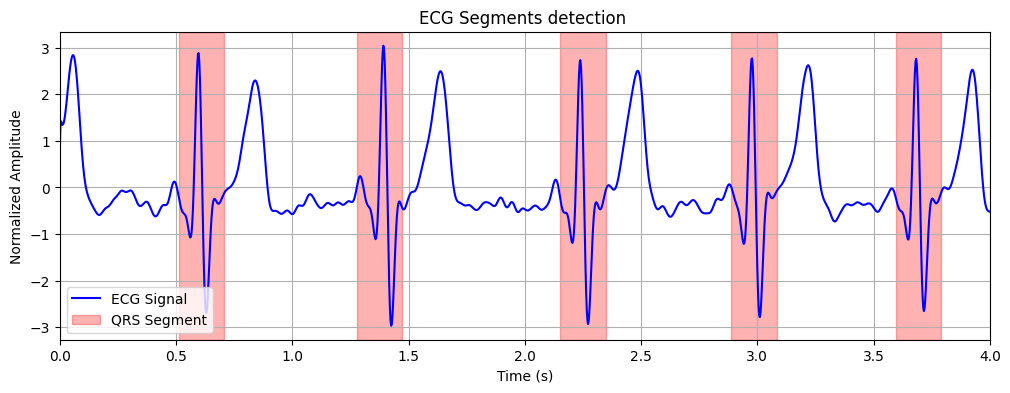

Number of positive (QRS) segments: 4
Number of negative (non-QRS) segments: 22


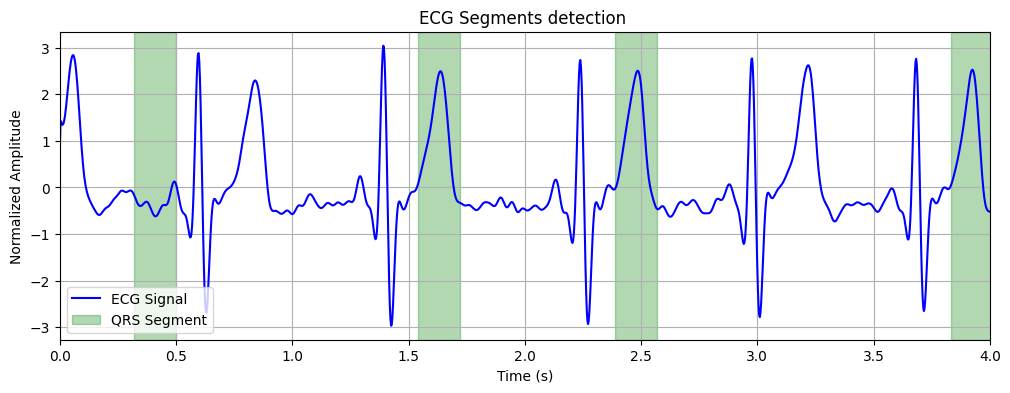

Number of positive (QRS) segments: 6
Number of negative (non-QRS) segments: 76


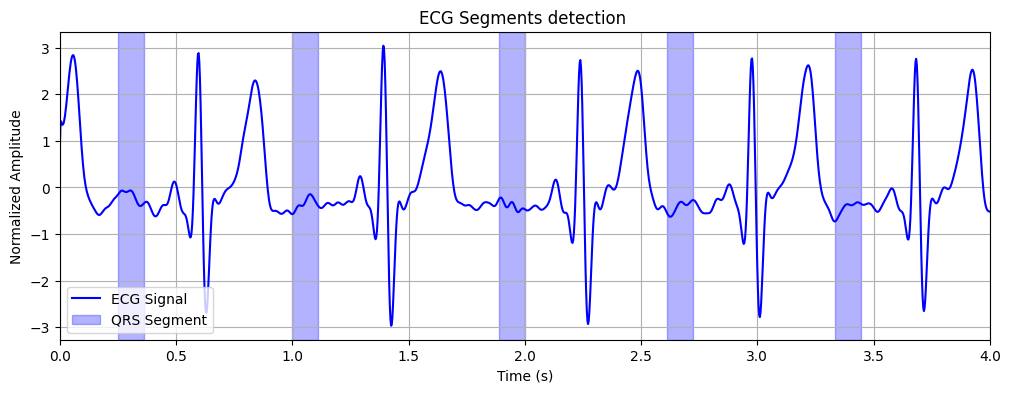

In [67]:
segment_labels=[QRS_predicted_labels,[],[]]
segment_starts=[QRS_new_start_segments,[],[]]
window_sizes = [QRS_window_size,0,0]
display_segment(normalized_signal = new_normalized_signal, segment_labels=segment_labels,segment_starts=segment_starts,z_start=0,z_end=4,window_sizes=window_sizes)

segment_labels=[[],[],T_predicted_labels]
segment_starts=[[],[],T_new_start_segments]
window_sizes = [0,0,T_window_size]
display_segment(normalized_signal = new_normalized_signal, segment_labels=segment_labels,segment_starts=segment_starts,z_start=0,z_end=4,window_sizes=window_sizes)

segment_labels=[[],P_predicted_labels,[]]
segment_starts=[[],P_new_start_segments,[]]
window_sizes = [0,P_window_size,0]
display_segment(normalized_signal = new_normalized_signal, segment_labels=segment_labels,segment_starts=segment_starts,z_start=0,z_end=4,window_sizes=window_sizes)

### ecgiddb Person_84/rec_2

#### load signal and preprocess

500
360


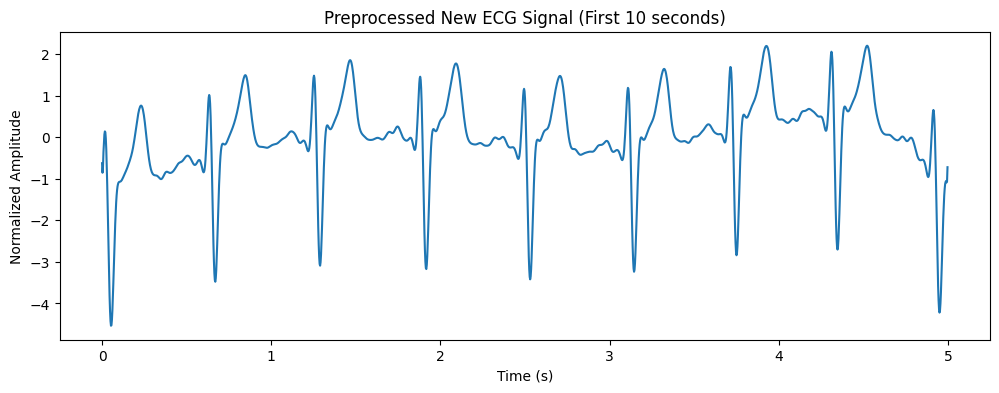

In [68]:
import wfdb
import numpy as np
import matplotlib.pyplot as plt
record_dir='/content/drive/MyDrive/Final project/dataset/physionet.org/files/ecgiddb/1.0.0/'
new_record_name='Person_84/rec_2'
new_record_name =  record_dir + new_record_name  # Change this to the desired record
new_record = wfdb.rdrecord(new_record_name)
new_ecg_signal = new_record.p_signal[:, 0]  # Assuming single-channel ECG
G_fs = new_record.fs
print(G_fs)
new_ecg_signal = new_ecg_signal[int(15 * G_fs):int(25 * G_fs)]
# Example usage
time_axis = np.arange(0, len(new_ecg_signal)) / G_fs  # Time axis in seconds

# Optionally smooth the signal
new_normalized_signal = normalize_signal(smooth_signal(bandpass_filter(new_ecg_signal, 1000), window_size=5))
if G_fs != 360:
            new_normalized_signal = resample_signal(new_normalized_signal, original_fs=G_fs, target_fs=360)
            G_fs = 360

print(G_fs)
# Visualize the preprocessed signal
import matplotlib.pyplot as plt
time_axis = [i / G_fs for i in range(len(new_normalized_signal))]
plt.figure(figsize=(12, 4))
plt.plot(time_axis[:G_fs * 10], new_normalized_signal[:G_fs * 10])
plt.title("Preprocessed New ECG Signal (First 10 seconds)")
plt.xlabel("Time (s)")
plt.ylabel("Normalized Amplitude")
plt.show()




In [69]:



# Segment the normalized signal
QRS_new_segments,QRS_new_start_segments = segment_signal(new_normalized_signal, window_size=QRS_window_size, overlap=QRS_overlap)
P_new_segments,P_new_start_segments = segment_signal(new_normalized_signal, window_size=P_window_size, overlap=P_overlap)
T_new_segments,T_new_start_segments = segment_signal(new_normalized_signal, window_size=T_window_size, overlap=T_overlap)

#print(f"Extracted {len(new_segments)} segments with window size {G_window_size} and {G_overlap} samples overlap.")



In [70]:
# Reshape segments for CNN+LSTM (adding a channel dimension)
QRS_new_segments = QRS_new_segments.reshape(QRS_new_segments.shape[0], QRS_new_segments.shape[1], 1)
P_new_segments = P_new_segments.reshape(P_new_segments.shape[0], P_new_segments.shape[1], 1)
T_new_segments = T_new_segments.reshape(T_new_segments.shape[0], T_new_segments.shape[1], 1)


# Print the shape
print("QRS shape of input segments for model:", QRS_new_segments.shape)
print("P shape of input segments for model:", P_new_segments.shape)
print("T shape of input segments for model:", T_new_segments.shape)


QRS shape of input segments for model: (347, 70, 1)
P shape of input segments for model: (177, 40, 1)
T shape of input segments for model: (348, 65, 1)


#### prediction

In [71]:
# Predict using the trained model
QRS_predictions = QRS_model.predict(QRS_new_segments)
P_predictions = P_model.predict(P_new_segments)
T_predictions = T_model.predict(T_new_segments)


# Convert predictions to binary labels (threshold at 0.5)
QRS_predicted_labels  = ( QRS_predictions > 0.5).astype(int)
T_predicted_labels    = ( T_predictions   > 0.5).astype(int)
P_predicted_labels    = ( P_predictions   > 0.5).astype(int)




11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


Number of positive (QRS) segments: 40
Number of negative (non-QRS) segments: 307
Number of positive (QRS) segments: 34
Number of negative (non-QRS) segments: 143
Number of positive (QRS) segments: 56
Number of negative (non-QRS) segments: 292


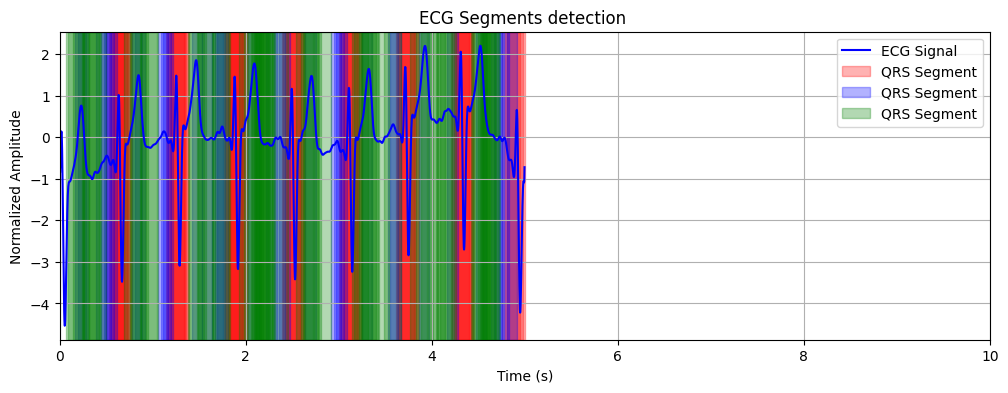

Number of positive (QRS) segments: 40
Number of negative (non-QRS) segments: 307
Number of positive (QRS) segments: 34
Number of negative (non-QRS) segments: 143
Number of positive (QRS) segments: 56
Number of negative (non-QRS) segments: 292


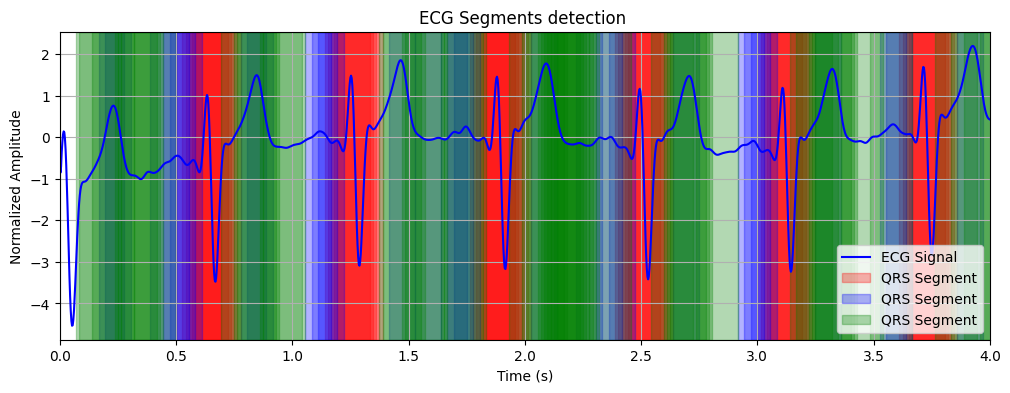

In [72]:
segment_labels=[QRS_predicted_labels,P_predicted_labels,T_predicted_labels]
segment_starts=[QRS_new_start_segments,P_new_start_segments,T_new_start_segments]
display_segment(normalized_signal = new_normalized_signal, segment_labels=segment_labels,segment_starts=segment_starts,z_start=0,z_end=10,window_sizes=display_window_sizes)
display_segment(normalized_signal = new_normalized_signal, segment_labels=segment_labels,segment_starts=segment_starts,z_start=0,z_end=4,window_sizes=display_window_sizes)

Number of positive (QRS) segments: 40
Number of negative (non-QRS) segments: 307


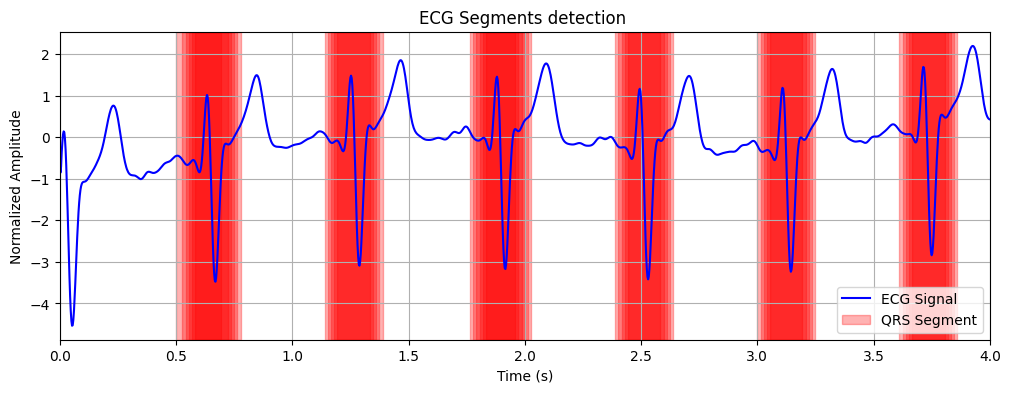

Number of positive (QRS) segments: 56
Number of negative (non-QRS) segments: 292


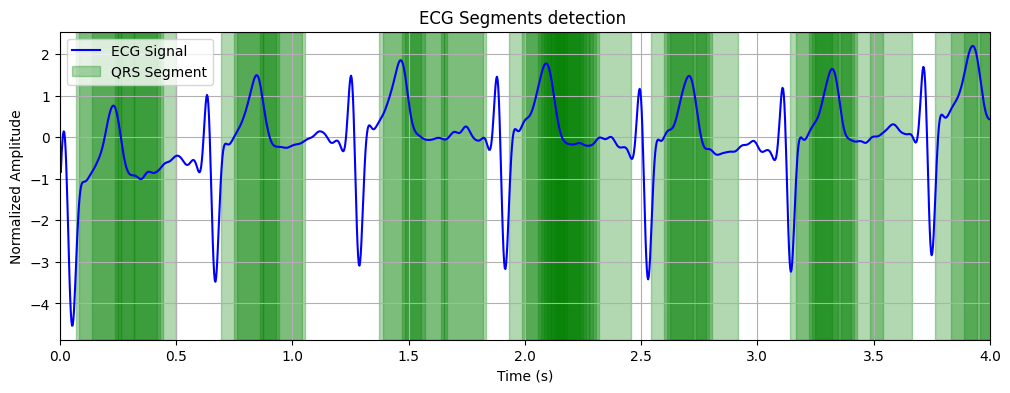

Number of positive (QRS) segments: 34
Number of negative (non-QRS) segments: 143


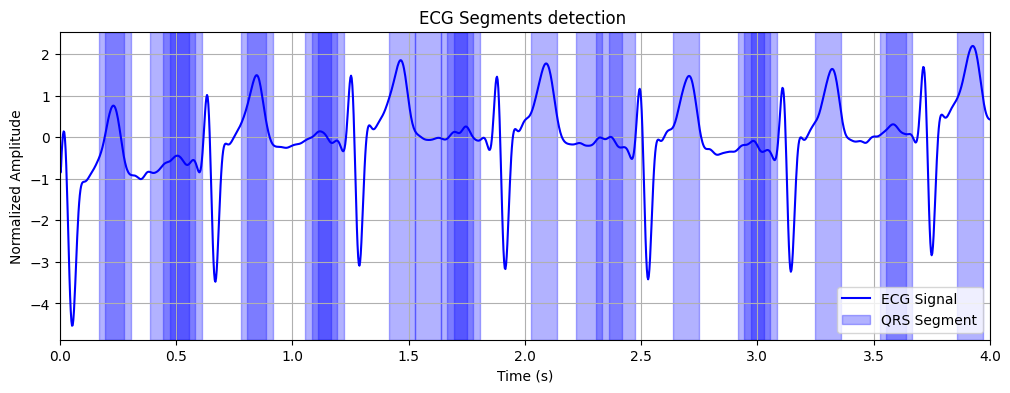

In [73]:
segment_labels=[QRS_predicted_labels,[],[]]
segment_starts=[QRS_new_start_segments,[],[]]
window_sizes = [QRS_window_size,0,0]
display_segment(normalized_signal = new_normalized_signal, segment_labels=segment_labels,segment_starts=segment_starts,z_start=0,z_end=4,window_sizes=window_sizes)

segment_labels=[[],[],T_predicted_labels]
segment_starts=[[],[],T_new_start_segments]
window_sizes = [0,0,T_window_size]
display_segment(normalized_signal = new_normalized_signal, segment_labels=segment_labels,segment_starts=segment_starts,z_start=0,z_end=4,window_sizes=window_sizes)

segment_labels=[[],P_predicted_labels,[]]
segment_starts=[[],P_new_start_segments,[]]
window_sizes = [0,P_window_size,0]
display_segment(normalized_signal = new_normalized_signal, segment_labels=segment_labels,segment_starts=segment_starts,z_start=0,z_end=4,window_sizes=window_sizes)

#### post process

In [74]:
QRS_predicted_labels, QRS_new_segments, QRS_new_start_segments = remove_short_qrs_predictions( QRS_predicted_labels, QRS_new_segments, QRS_new_start_segments,opt="mid")

In [75]:
P_predicted_labels, P_new_segments, P_new_start_segments = remove_consecutive_ones( P_predicted_labels, P_new_segments, P_new_start_segments,opt="mid")

In [76]:
T_predicted_labels, T_new_segments, T_new_start_segments = remove_consecutive_ones( T_predicted_labels, T_new_segments, T_new_start_segments,opt="mid")

In [77]:
QRS_predicted_labels, QRS_new_segments, QRS_new_start_segments = remove_touching_negatives( QRS_predicted_labels, QRS_new_segments, QRS_new_start_segments,QRS_window_size,QRS_overlap)
QRS_predicted_labels, QRS_new_segments, QRS_new_start_segments = remove_consecutive_ones( QRS_predicted_labels, QRS_new_segments, QRS_new_start_segments,opt="mid")


Number of windows to remove: 13


In [78]:
P_predicted_labels, P_new_segments, P_new_start_segments = remove_touching_negatives( P_predicted_labels, P_new_segments, P_new_start_segments,P_window_size,P_overlap)
P_predicted_labels, P_new_segments, P_new_start_segments = remove_consecutive_ones( P_predicted_labels, P_new_segments, P_new_start_segments,opt="mid")


Number of windows to remove: 3


In [79]:
T_predicted_labels, T_new_segments, T_new_start_segments = remove_touching_negatives( T_predicted_labels, T_new_segments, T_new_start_segments,T_window_size,T_overlap)
T_predicted_labels, T_new_segments, T_new_start_segments = remove_consecutive_ones( T_predicted_labels, T_new_segments, T_new_start_segments,opt="mid")

Number of windows to remove: 12


Number of positive (QRS) segments: 7
Number of negative (non-QRS) segments: 124
Number of positive (QRS) segments: 12
Number of negative (non-QRS) segments: 41
Number of positive (QRS) segments: 4
Number of negative (non-QRS) segments: 22


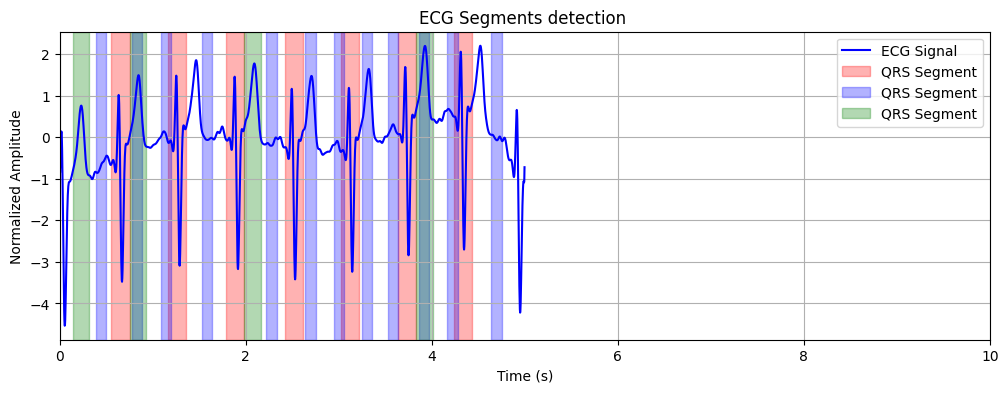

Number of positive (QRS) segments: 7
Number of negative (non-QRS) segments: 124
Number of positive (QRS) segments: 12
Number of negative (non-QRS) segments: 41
Number of positive (QRS) segments: 4
Number of negative (non-QRS) segments: 22


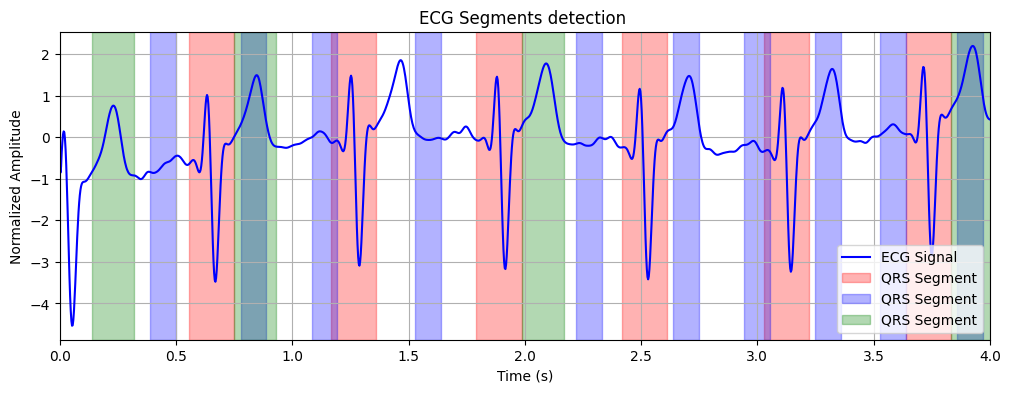

In [80]:
segment_labels=[QRS_predicted_labels,P_predicted_labels,T_predicted_labels]
segment_starts=[QRS_new_start_segments,P_new_start_segments,T_new_start_segments]
display_segment(normalized_signal = new_normalized_signal, segment_labels=segment_labels,segment_starts=segment_starts,z_start=0,z_end=10,window_sizes=display_window_sizes)
display_segment(normalized_signal = new_normalized_signal, segment_labels=segment_labels,segment_starts=segment_starts,z_start=0,z_end=4,window_sizes=display_window_sizes)

Number of positive (QRS) segments: 7
Number of negative (non-QRS) segments: 124


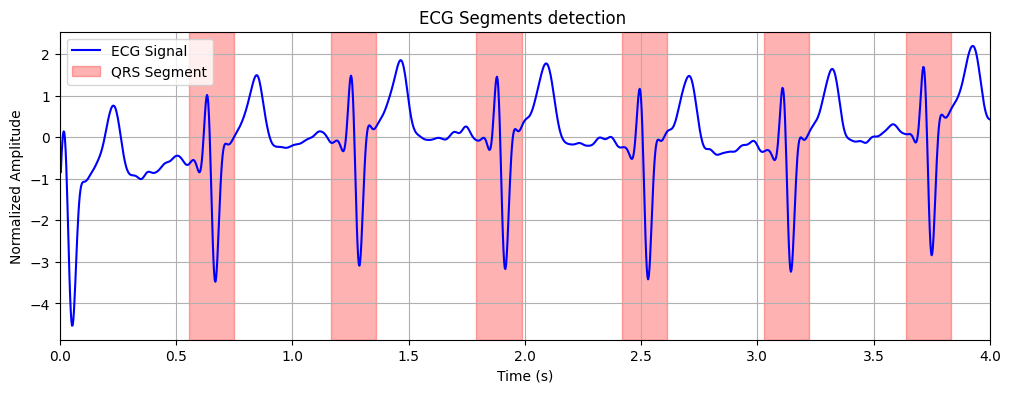

Number of positive (QRS) segments: 4
Number of negative (non-QRS) segments: 22


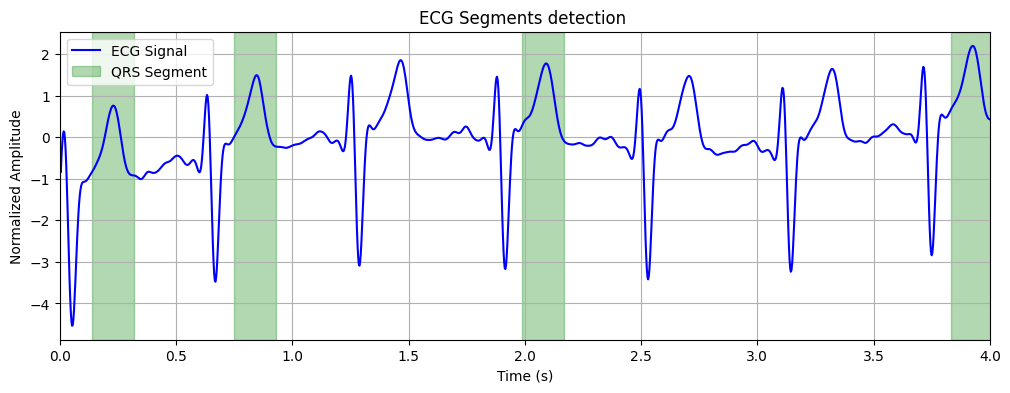

Number of positive (QRS) segments: 12
Number of negative (non-QRS) segments: 41


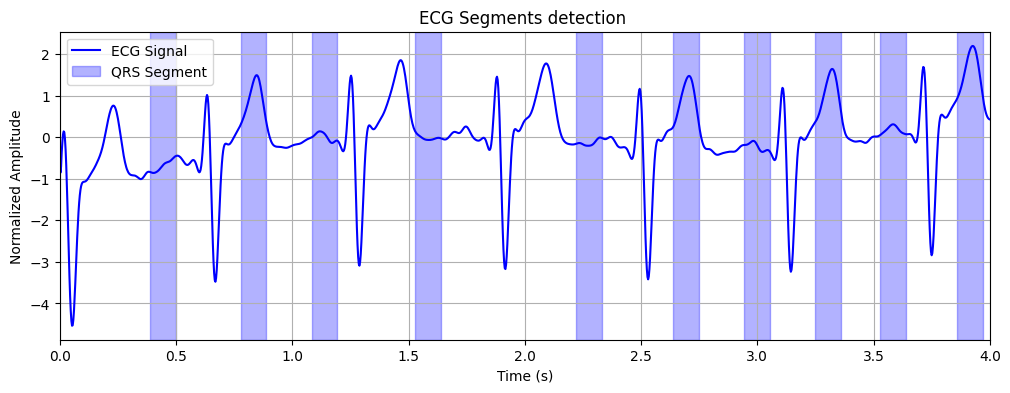

In [81]:
segment_labels=[QRS_predicted_labels,[],[]]
segment_starts=[QRS_new_start_segments,[],[]]
window_sizes = [QRS_window_size,0,0]
display_segment(normalized_signal = new_normalized_signal, segment_labels=segment_labels,segment_starts=segment_starts,z_start=0,z_end=4,window_sizes=window_sizes)

segment_labels=[[],[],T_predicted_labels]
segment_starts=[[],[],T_new_start_segments]
window_sizes = [0,0,T_window_size]
display_segment(normalized_signal = new_normalized_signal, segment_labels=segment_labels,segment_starts=segment_starts,z_start=0,z_end=4,window_sizes=window_sizes)

segment_labels=[[],P_predicted_labels,[]]
segment_starts=[[],P_new_start_segments,[]]
window_sizes = [0,P_window_size,0]
display_segment(normalized_signal = new_normalized_signal, segment_labels=segment_labels,segment_starts=segment_starts,z_start=0,z_end=4,window_sizes=window_sizes)

### ecgiddb Person_48/rec_1

#### load signal and preprocess

500
360


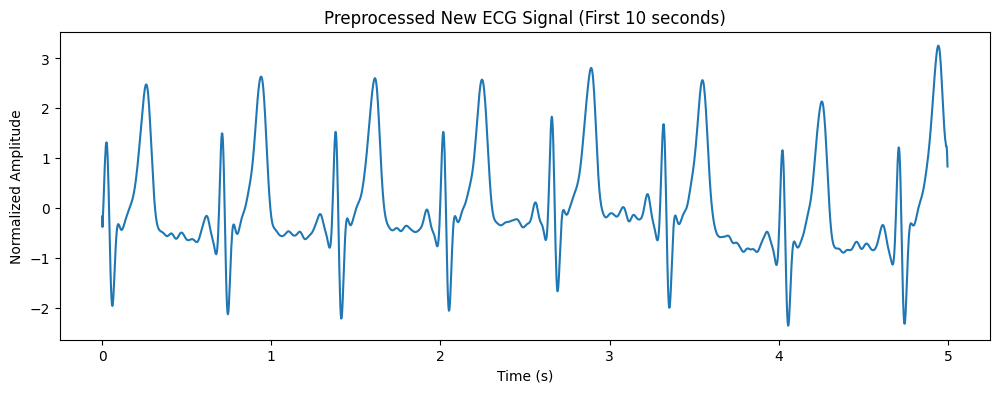

In [82]:
import wfdb
import numpy as np
import matplotlib.pyplot as plt
record_dir='/content/drive/MyDrive/Final project/dataset/physionet.org/files/ecgiddb/1.0.0/'
new_record_name='Person_48/rec_1'
new_record_name =  record_dir + new_record_name  # Change this to the desired record
new_record = wfdb.rdrecord(new_record_name)
new_ecg_signal = new_record.p_signal[:, 0]  # Assuming single-channel ECG
G_fs = new_record.fs
print(G_fs)
new_ecg_signal = new_ecg_signal[int(15 * G_fs):int(25 * G_fs)]
# Example usage
time_axis = np.arange(0, len(new_ecg_signal)) / G_fs  # Time axis in seconds

# Optionally smooth the signal
new_normalized_signal = normalize_signal(smooth_signal(bandpass_filter(new_ecg_signal, 1000), window_size=5))
if G_fs != 360:
            new_normalized_signal = resample_signal(new_normalized_signal, original_fs=G_fs, target_fs=360)
            G_fs = 360

print(G_fs)
# Visualize the preprocessed signal
import matplotlib.pyplot as plt
time_axis = [i / G_fs for i in range(len(new_normalized_signal))]
plt.figure(figsize=(12, 4))
plt.plot(time_axis[:G_fs * 10], new_normalized_signal[:G_fs * 10])
plt.title("Preprocessed New ECG Signal (First 10 seconds)")
plt.xlabel("Time (s)")
plt.ylabel("Normalized Amplitude")
plt.show()




In [83]:



# Segment the normalized signal
QRS_new_segments,QRS_new_start_segments = segment_signal(new_normalized_signal, window_size=QRS_window_size, overlap=QRS_overlap)
P_new_segments,P_new_start_segments = segment_signal(new_normalized_signal, window_size=P_window_size, overlap=P_overlap)
T_new_segments,T_new_start_segments = segment_signal(new_normalized_signal, window_size=T_window_size, overlap=T_overlap)

#print(f"Extracted {len(new_segments)} segments with window size {G_window_size} and {G_overlap} samples overlap.")



In [84]:
# Reshape segments for CNN+LSTM (adding a channel dimension)
QRS_new_segments = QRS_new_segments.reshape(QRS_new_segments.shape[0], QRS_new_segments.shape[1], 1)
P_new_segments = P_new_segments.reshape(P_new_segments.shape[0], P_new_segments.shape[1], 1)
T_new_segments = T_new_segments.reshape(T_new_segments.shape[0], T_new_segments.shape[1], 1)


# Print the shape
print("QRS shape of input segments for model:", QRS_new_segments.shape)
print("P shape of input segments for model:", P_new_segments.shape)
print("T shape of input segments for model:", T_new_segments.shape)


QRS shape of input segments for model: (347, 70, 1)
P shape of input segments for model: (177, 40, 1)
T shape of input segments for model: (348, 65, 1)


#### prediction

In [85]:
# Predict using the trained model
QRS_predictions = QRS_model.predict(QRS_new_segments)
P_predictions = P_model.predict(P_new_segments)
T_predictions = T_model.predict(T_new_segments)


# Convert predictions to binary labels (threshold at 0.5)
QRS_predicted_labels  = ( QRS_predictions > 0.5).astype(int)
T_predicted_labels    = ( T_predictions   > 0.5).astype(int)
P_predicted_labels    = ( P_predictions   > 0.5).astype(int)




11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


Number of positive (QRS) segments: 42
Number of negative (non-QRS) segments: 305
Number of positive (QRS) segments: 26
Number of negative (non-QRS) segments: 151
Number of positive (QRS) segments: 55
Number of negative (non-QRS) segments: 293


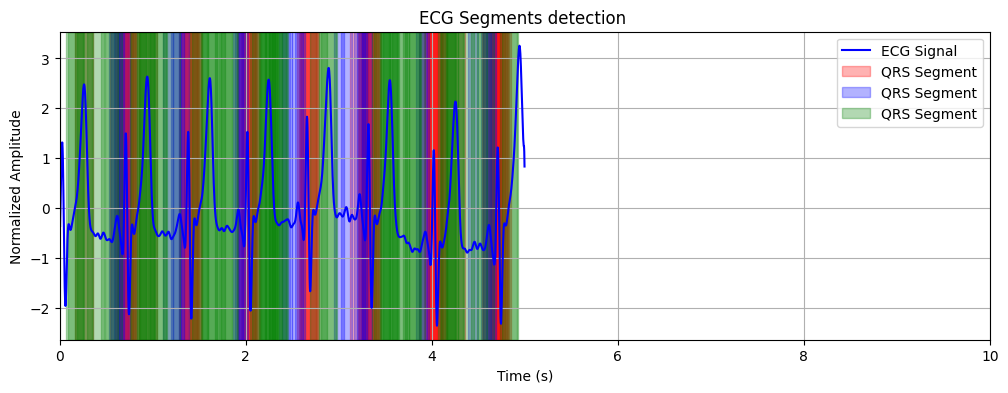

Number of positive (QRS) segments: 42
Number of negative (non-QRS) segments: 305
Number of positive (QRS) segments: 26
Number of negative (non-QRS) segments: 151
Number of positive (QRS) segments: 55
Number of negative (non-QRS) segments: 293


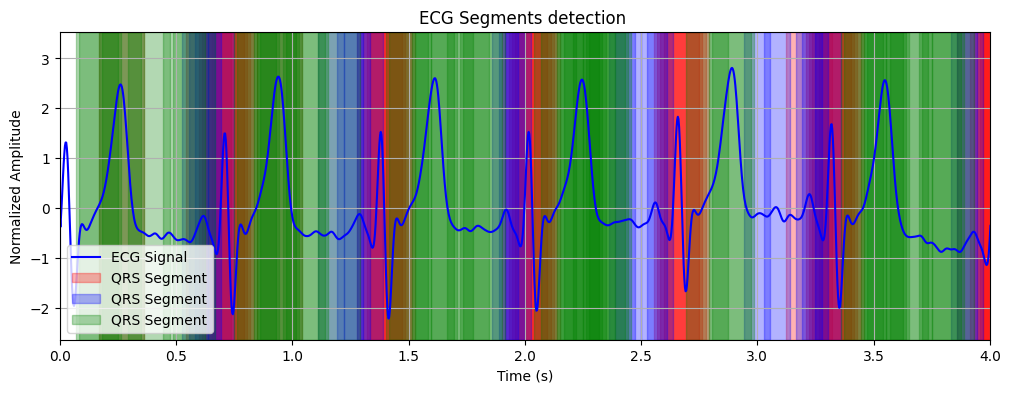

In [86]:
segment_labels=[QRS_predicted_labels,P_predicted_labels,T_predicted_labels]
segment_starts=[QRS_new_start_segments,P_new_start_segments,T_new_start_segments]
display_segment(normalized_signal = new_normalized_signal, segment_labels=segment_labels,segment_starts=segment_starts,z_start=0,z_end=10,window_sizes=display_window_sizes)
display_segment(normalized_signal = new_normalized_signal, segment_labels=segment_labels,segment_starts=segment_starts,z_start=0,z_end=4,window_sizes=display_window_sizes)

Number of positive (QRS) segments: 42
Number of negative (non-QRS) segments: 305


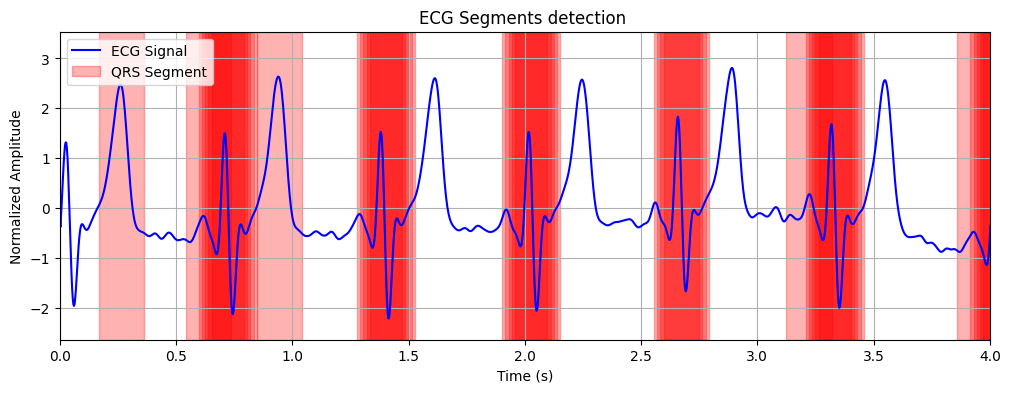

Number of positive (QRS) segments: 55
Number of negative (non-QRS) segments: 293


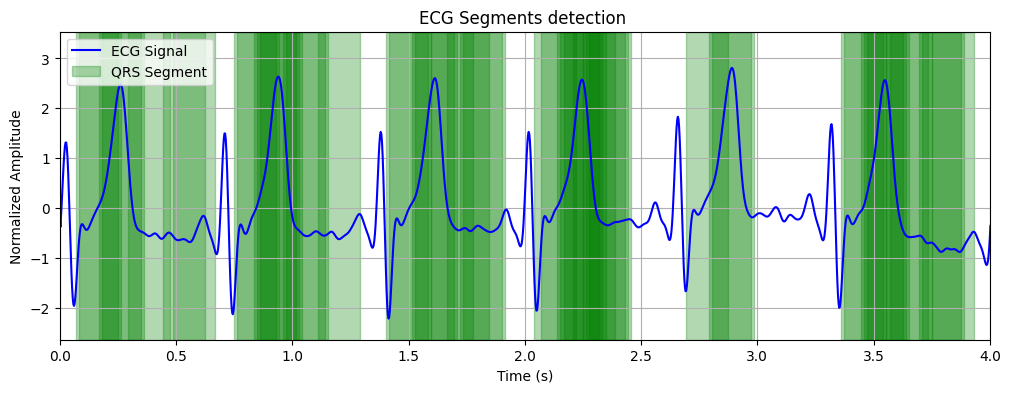

Number of positive (QRS) segments: 26
Number of negative (non-QRS) segments: 151


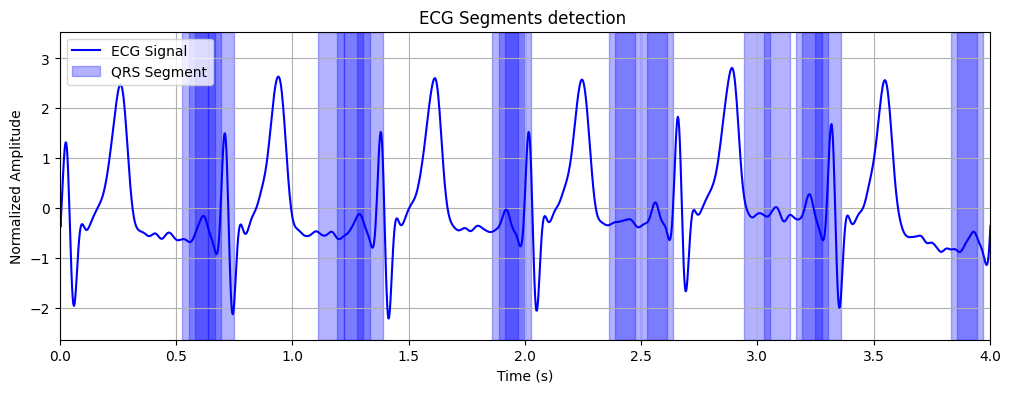

In [87]:
segment_labels=[QRS_predicted_labels,[],[]]
segment_starts=[QRS_new_start_segments,[],[]]
window_sizes = [QRS_window_size,0,0]
display_segment(normalized_signal = new_normalized_signal, segment_labels=segment_labels,segment_starts=segment_starts,z_start=0,z_end=4,window_sizes=window_sizes)

segment_labels=[[],[],T_predicted_labels]
segment_starts=[[],[],T_new_start_segments]
window_sizes = [0,0,T_window_size]
display_segment(normalized_signal = new_normalized_signal, segment_labels=segment_labels,segment_starts=segment_starts,z_start=0,z_end=4,window_sizes=window_sizes)

segment_labels=[[],P_predicted_labels,[]]
segment_starts=[[],P_new_start_segments,[]]
window_sizes = [0,P_window_size,0]
display_segment(normalized_signal = new_normalized_signal, segment_labels=segment_labels,segment_starts=segment_starts,z_start=0,z_end=4,window_sizes=window_sizes)

#### post process

In [88]:
QRS_predicted_labels, QRS_new_segments, QRS_new_start_segments = remove_short_qrs_predictions( QRS_predicted_labels, QRS_new_segments, QRS_new_start_segments,opt="mid")

In [89]:
P_predicted_labels, P_new_segments, P_new_start_segments = remove_consecutive_ones( P_predicted_labels, P_new_segments, P_new_start_segments,opt="mid")

In [90]:
T_predicted_labels, T_new_segments, T_new_start_segments = remove_consecutive_ones( T_predicted_labels, T_new_segments, T_new_start_segments,opt="mid")

In [91]:
QRS_predicted_labels, QRS_new_segments, QRS_new_start_segments = remove_touching_negatives( QRS_predicted_labels, QRS_new_segments, QRS_new_start_segments,QRS_window_size,QRS_overlap)
QRS_predicted_labels, QRS_new_segments, QRS_new_start_segments = remove_consecutive_ones( QRS_predicted_labels, QRS_new_segments, QRS_new_start_segments,opt="mid")


Number of windows to remove: 13


In [92]:
P_predicted_labels, P_new_segments, P_new_start_segments = remove_touching_negatives( P_predicted_labels, P_new_segments, P_new_start_segments,P_window_size,P_overlap)
P_predicted_labels, P_new_segments, P_new_start_segments = remove_consecutive_ones( P_predicted_labels, P_new_segments, P_new_start_segments,opt="mid")


Number of windows to remove: 3


In [93]:
T_predicted_labels, T_new_segments, T_new_start_segments = remove_touching_negatives( T_predicted_labels, T_new_segments, T_new_start_segments,T_window_size,T_overlap)
T_predicted_labels, T_new_segments, T_new_start_segments = remove_consecutive_ones( T_predicted_labels, T_new_segments, T_new_start_segments,opt="mid")

Number of windows to remove: 12


Number of positive (QRS) segments: 6
Number of negative (non-QRS) segments: 125
Number of positive (QRS) segments: 7
Number of negative (non-QRS) segments: 89
Number of positive (QRS) segments: 3
Number of negative (non-QRS) segments: 20


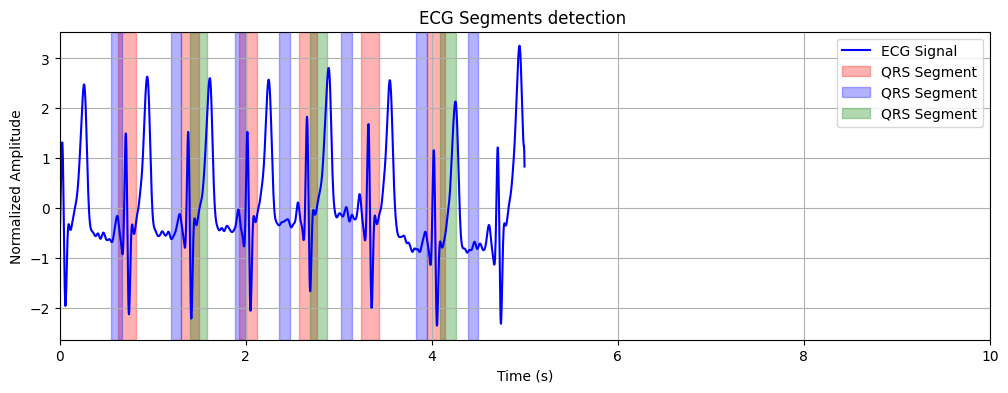

Number of positive (QRS) segments: 6
Number of negative (non-QRS) segments: 125
Number of positive (QRS) segments: 7
Number of negative (non-QRS) segments: 89
Number of positive (QRS) segments: 3
Number of negative (non-QRS) segments: 20


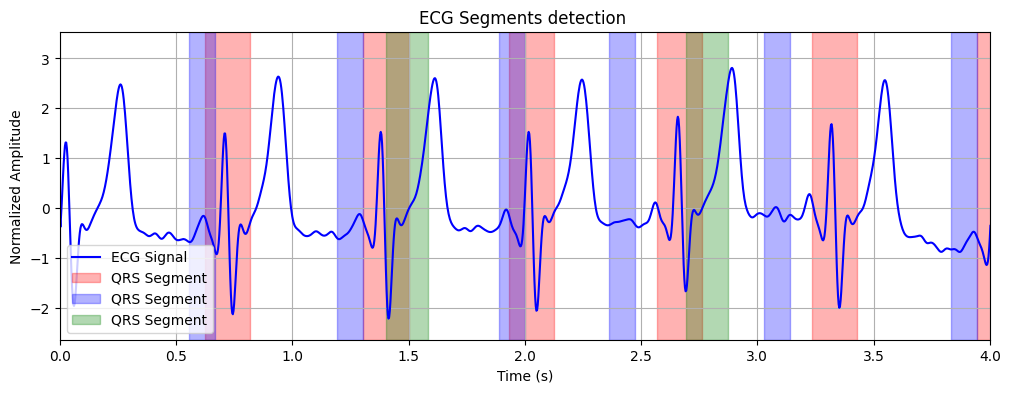

In [94]:
segment_labels=[QRS_predicted_labels,P_predicted_labels,T_predicted_labels]
segment_starts=[QRS_new_start_segments,P_new_start_segments,T_new_start_segments]
display_segment(normalized_signal = new_normalized_signal, segment_labels=segment_labels,segment_starts=segment_starts,z_start=0,z_end=10,window_sizes=display_window_sizes)
display_segment(normalized_signal = new_normalized_signal, segment_labels=segment_labels,segment_starts=segment_starts,z_start=0,z_end=4,window_sizes=display_window_sizes)

Number of positive (QRS) segments: 6
Number of negative (non-QRS) segments: 125


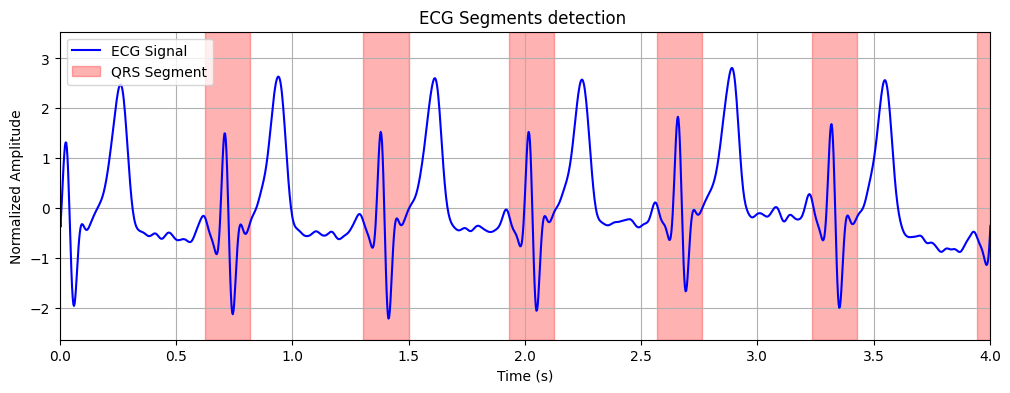

Number of positive (QRS) segments: 3
Number of negative (non-QRS) segments: 20


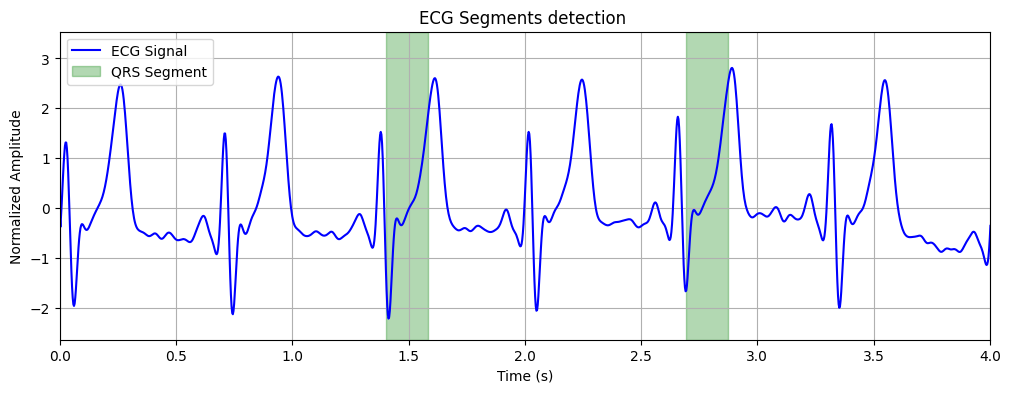

Number of positive (QRS) segments: 7
Number of negative (non-QRS) segments: 89


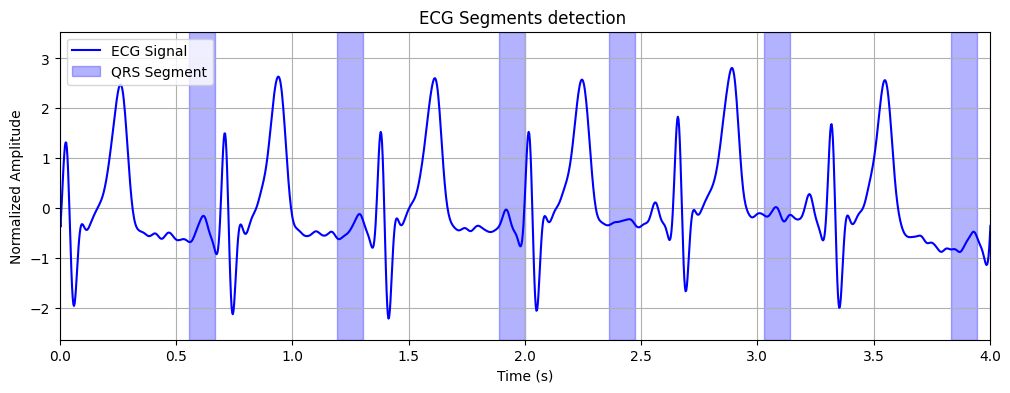

In [95]:
segment_labels=[QRS_predicted_labels,[],[]]
segment_starts=[QRS_new_start_segments,[],[]]
window_sizes = [QRS_window_size,0,0]
display_segment(normalized_signal = new_normalized_signal, segment_labels=segment_labels,segment_starts=segment_starts,z_start=0,z_end=4,window_sizes=window_sizes)

segment_labels=[[],[],T_predicted_labels]
segment_starts=[[],[],T_new_start_segments]
window_sizes = [0,0,T_window_size]
display_segment(normalized_signal = new_normalized_signal, segment_labels=segment_labels,segment_starts=segment_starts,z_start=0,z_end=4,window_sizes=window_sizes)

segment_labels=[[],P_predicted_labels,[]]
segment_starts=[[],P_new_start_segments,[]]
window_sizes = [0,P_window_size,0]
display_segment(normalized_signal = new_normalized_signal, segment_labels=segment_labels,segment_starts=segment_starts,z_start=0,z_end=4,window_sizes=window_sizes)